两张图片的评估指标


In [88]:
from skimage.metrics import structural_similarity as ssim
import cv2
# 导入必要的库
# 导入CV


In [89]:
def mean_squared_error(img1, img2):
    assert img1.shape == img2.shape, "images have different shape {} and {}".format(img1.shape, img2.shape)
    img_mse = np.mean((img1.astype(np.float64) - img2.astype(np.float64))**2)
    img_sim = img_mse / (255**2)
    return img_mse, 1 - img_sim

def root_mean_squared_error(img1, img2):
    assert img1.shape == img2.shape, "images have different shape {} and {}".format(img1.shape, img2.shape)
    img_rmse = np.sqrt(np.mean((img1.astype(np.float64) - img2.astype(np.float64))**2))
    img_sim = img_rmse / 255
    return img_rmse, 1 - img_sim


def peak_signal_noise_ratio(img1, img2):
    """
    PSNR(Peak Signal Noise Ratio)也叫峰值信噪比, PSNR的值越大表示图像越相似
    """
    # 判断两张图片的size是否一致
    assert img1.shape == img2.shape, "images hava different shape " \
        "{} and {}".format(img1.shape, img2.shape)
    # 获取数据类型所表示的最大值
    MAX = np.iinfo(img1.dtype).max
    # 计算两张图片的MSE
    mse, _ = mean_squared_error(img1, img2)
    if mse == 0:
        return float('inf')
    # 计算两张图片的PSNR
    psnr = 10 * np.log10(MAX**2 / mse)

    return psnr


def calculate_ssim(image1, image2):
    # 如果图像是彩色的，先将它们转换为灰度图像
    if len(image1.shape) == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    if len(image2.shape) == 3:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    # 计算SSIM
    ssim_value, _ = ssim(image1, image2, full=True)
    return ssim_value


# 一维算例

In [30]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [50]:
def generate_data(num_samples, size):
    x = np.linspace(-np.pi, np.pi, size)
    t = np.linspace(0, 10, size)
    X, T = np.meshgrid(x, t, indexing='ij')
    data = []
    for _ in range(num_samples):
        a = np.sin(X - T)
        b = np.cos(X + T)
        c = np.sin(X + T)
        d = np.cos(X - T)
        
        # 计算梯度
        dx = x[1] - x[0]
        a_grad_x, a_grad_y = np.gradient(a, dx, dx)
        b_grad_x, b_grad_y = np.gradient(b, dx, dx)
        c_grad_x, c_grad_y = np.gradient(c, dx, dx)
        d_grad_x, d_grad_y = np.gradient(d, dx, dx)
        
        # 根据公式计算u
        u = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
        data.append((u, np.stack((a, b, c, d), axis=0)))
    return data


In [51]:
def compute_u(a, b, c, d, dx):
    # 计算梯度
    a_grad_x, a_grad_y = np.gradient(a, dx, dx)
    b_grad_x, b_grad_y = np.gradient(b, dx, dx)
    c_grad_x, c_grad_y = np.gradient(c, dx, dx)
    d_grad_x, d_grad_y = np.gradient(d, dx, dx)
    
    # 根据公式计算u
    u_pre_x = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
    u_pre_y = a * b_grad_y - b * a_grad_y + c * d_grad_y - d * c_grad_y

    u_pre = u_pre_x + u_pre_y
    return u_pre

In [52]:
# 准备训练和测试数据
num_samples = 2000
size = 32  # 调整分辨率为 32x32
data = generate_data(num_samples, size)
train_data = data[:1000]
test_data = data[1000:]
shared_train_data = train_data
shared_test_data = test_data


In [53]:
# 自定义数据集
class VelocityDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        u, params = self.data[idx]
        return torch.tensor(u, dtype=torch.float32).unsqueeze(0), torch.tensor(params, dtype=torch.float32)


In [54]:
train_dataset = VelocityDataset(shared_train_data)
test_dataset = VelocityDataset(shared_test_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


In [55]:
# 模型定义
class VelocityPredictor(nn.Module):
    def __init__(self, size):
        super(VelocityPredictor, self).__init__()
        self.size = size
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * size * size, 512)  # 128 channels * size * size
        self.fc2 = nn.Linear(512, 4 * size * size)    # 4 channels * size * size

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, 4, self.size, self.size)  # Reshape the output tensor
        return x


In [56]:
# 计算速度场
def compute_velocity(a, b, c, d):
    dx = 1.0 / a.size(-1)  # 假设均匀网格
    a_grad_x, a_grad_y = torch.gradient(a, spacing=(dx, dx), dim=(1, 2))
    b_grad_x, b_grad_y = torch.gradient(b, spacing=(dx, dx), dim=(1, 2))
    c_grad_x, c_grad_y = torch.gradient(c, spacing=(dx, dx), dim=(1, 2))
    d_grad_x, d_grad_y = torch.gradient(d, spacing=(dx, dx), dim=(1, 2))

    u_pre_x = a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x
    u_pre_y = a * b_grad_y - b * a_grad_y + c * d_grad_y - d * c_grad_y

    return u_pre_x + u_pre_y


In [57]:
# 训练模型
num_epochs = 50
model = VelocityPredictor(size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [58]:
for epoch in range(num_epochs):
    model.train()
    for u, params in train_loader:
        optimizer.zero_grad()
        outputs = model(u)
        
        # 获取参数
        a = outputs[:, 0, :, :].requires_grad_(True)
        b = outputs[:, 1, :, :].requires_grad_(True)
        c = outputs[:, 2, :, :].requires_grad_(True)
        d = outputs[:, 3, :, :].requires_grad_(True)
        
        u_pred = compute_velocity(a, b, c, d)
        loss = criterion(u_pred, u.squeeze(1))
        loss.backward()
        optimizer.step()

    if epoch % 1 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


Epoch 1/50, Loss: 0.0007063839002512395
Epoch 2/50, Loss: 2.4646444217069075e-05
Epoch 3/50, Loss: 0.0003147526003886014
Epoch 4/50, Loss: 3.638294856500579e-06
Epoch 5/50, Loss: 1.390786565025337e-06
Epoch 6/50, Loss: 6.980457101235515e-07
Epoch 7/50, Loss: 0.001160570653155446
Epoch 8/50, Loss: 2.889394409066881e-06
Epoch 9/50, Loss: 1.0893581503523819e-07
Epoch 10/50, Loss: 6.52559108971218e-08
Epoch 11/50, Loss: 4.3057127641077386e-08
Epoch 12/50, Loss: 2.9440974103067674e-08
Epoch 13/50, Loss: 2.0278728030120874e-08
Epoch 14/50, Loss: 1.387609049885441e-08
Epoch 15/50, Loss: 9.372248754857537e-09
Epoch 16/50, Loss: 6.2302341063968925e-09
Epoch 17/50, Loss: 0.0007153289625421166
Epoch 18/50, Loss: 1.5125361869650078e-06
Epoch 19/50, Loss: 1.2779734603896031e-08
Epoch 20/50, Loss: 4.601379721691501e-09
Epoch 21/50, Loss: 1.9000392370571717e-09
Epoch 22/50, Loss: 8.182090005526277e-10
Epoch 23/50, Loss: 3.656330793688767e-10
Epoch 24/50, Loss: 1.6864513951997395e-10
Epoch 25/50, Loss

In [59]:
# 测试模型
model.eval()

VelocityPredictor(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=131072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4096, bias=True)
)

In [60]:
with torch.no_grad():
    test_targets = []
    test_predictions = []
    a_predictions = []
    b_predictions = []
    c_predictions = []
    d_predictions = []
    
    for u, params in test_loader:
        outputs = model(u)
        
        # 获取参数
        a = outputs[:, 0, :, :]
        b = outputs[:, 1, :, :]
        c = outputs[:, 2, :, :]
        d = outputs[:, 3, :, :]
        
        u_pred = compute_velocity(a, b, c, d)
        test_targets.append(u.numpy())
        test_predictions.append(u_pred.numpy())
        
        a_predictions.append(a.numpy())
        b_predictions.append(b.numpy())
        c_predictions.append(c.numpy())
        d_predictions.append(d.numpy())

    if test_targets:
        test_targets = np.concatenate(test_targets)
        test_predictions = np.concatenate(test_predictions)
    else:
        test_targets = np.array(test_targets)
        test_predictions = np.array(test_predictions)

    if a_predictions:
        a_predictions = np.concatenate(a_predictions)
        b_predictions = np.concatenate(b_predictions)
        c_predictions = np.concatenate(c_predictions)
        d_predictions = np.concatenate(d_predictions)
    else:
        a_predictions = np.array(a_predictions)
        b_predictions = np.array(b_predictions)
        c_predictions = np.array(c_predictions)
        d_predictions = np.array(d_predictions)

    mse = mean_squared_error(test_targets.flatten(), test_predictions.flatten())
    mae = mean_absolute_error(test_targets.flatten(), test_predictions.flatten())
    r2 = r2_score(test_targets.flatten(), test_predictions.flatten())

    print(f'Test Mean Squared Error: {mse}')
    print(f'Test Mean Absolute Error: {mae}')
    print(f'Test R^2 Score: {r2}')

Test Mean Squared Error: 4.321460791750949e-14
Test Mean Absolute Error: 1.5450488888291147e-07
Test R^2 Score: 1.0


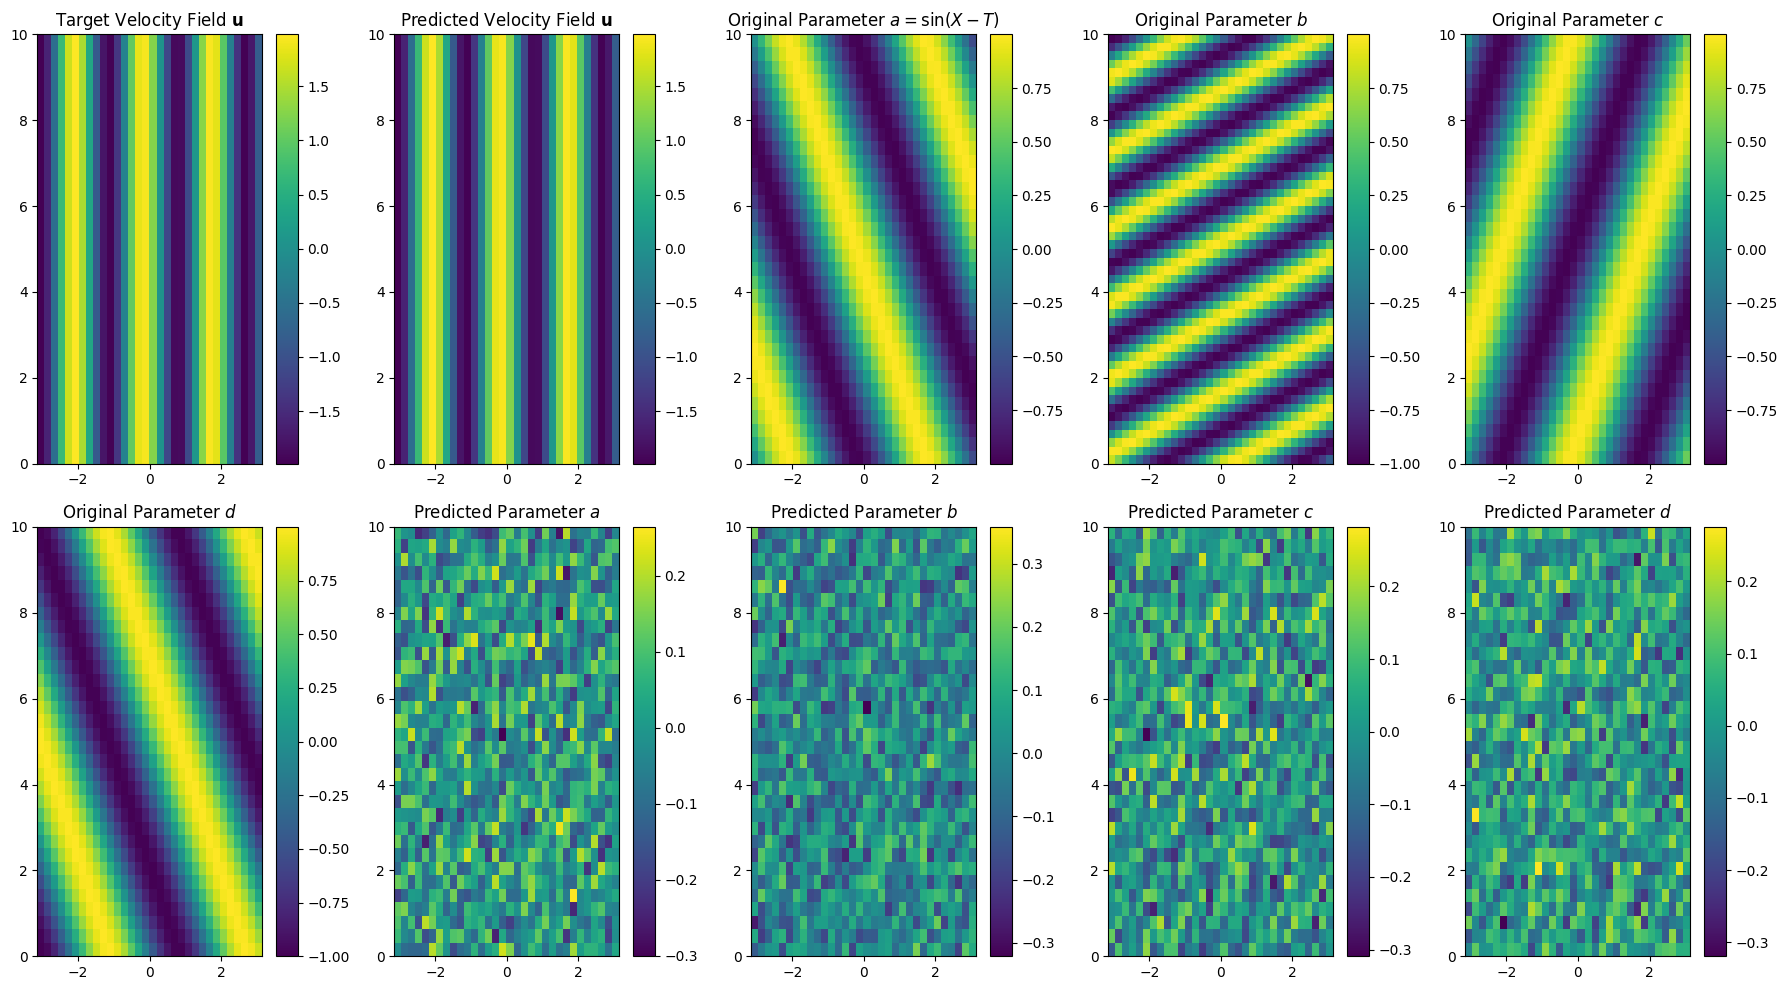

In [61]:
# 可视化结果
plt.figure(figsize=(18, 10))

# 绘制目标速度场
plt.subplot(2, 5, 1)
if test_targets.size > 0:
    plt.imshow(test_targets[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Target Velocity Field $\\mathbf{u}$')

# 绘制预测速度场
plt.subplot(2, 5, 2)
if test_predictions.size > 0:
    plt.imshow(test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Velocity Field $\\mathbf{u}$')

# 绘制原始和预测的 a 参数对比图
plt.subplot(2, 5, 3)
plt.imshow(np.sin(np.linspace(-np.pi, np.pi, size)[:, None] - np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $a = \sin(X - T)$')

plt.subplot(2, 5, 7)
if a_predictions.size > 0:
    plt.imshow(a_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $a$')

# 绘制原始和预测的 b 参数对比图
plt.subplot(2, 5, 4)
plt.imshow(np.cos(np.linspace(-np.pi, size)[:, None] + np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $b$')

plt.subplot(2, 5, 8)
if b_predictions.size > 0:
    plt.imshow(b_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $b$')

# 绘制原始和预测的 c 参数对比图
plt.subplot(2, 5, 5)
plt.imshow(np.sin(np.linspace(-np.pi, np.pi, size)[:, None] + np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $c$')

plt.subplot(2, 5, 9)
if c_predictions.size > 0:
    plt.imshow(c_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $c$')

# 绘制原始和预测的 d 参数对比图
plt.subplot(2, 5, 6)
plt.imshow(np.cos(np.linspace(-np.pi, np.pi, size)[:, None] - np.linspace(0, 10, size)[None, :]), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Original Parameter $d$')

plt.subplot(2, 5, 10)
if d_predictions.size > 0:
    plt.imshow(d_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('Predicted Parameter $d$')

plt.tight_layout()
plt.show()

In [74]:
aPre = a_predictions[0].squeeze().copy()
bPre = b_predictions[0].squeeze().copy()
cPre = c_predictions[0].squeeze().copy()
dPre = d_predictions[0].squeeze().copy()


In [76]:
u111 =  compute_u(aPre, bPre, cPre, dPre, dx)
plt.imshow(u111, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')

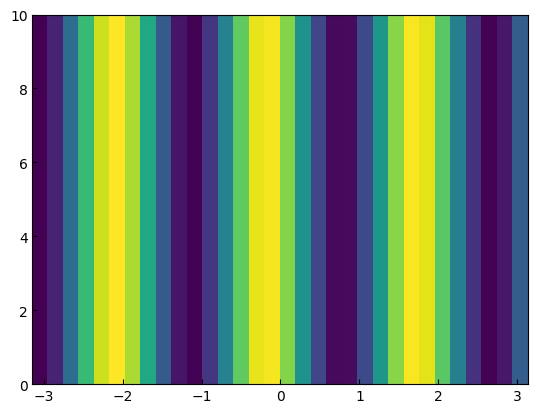

In [77]:
plt.imshow(u111, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')

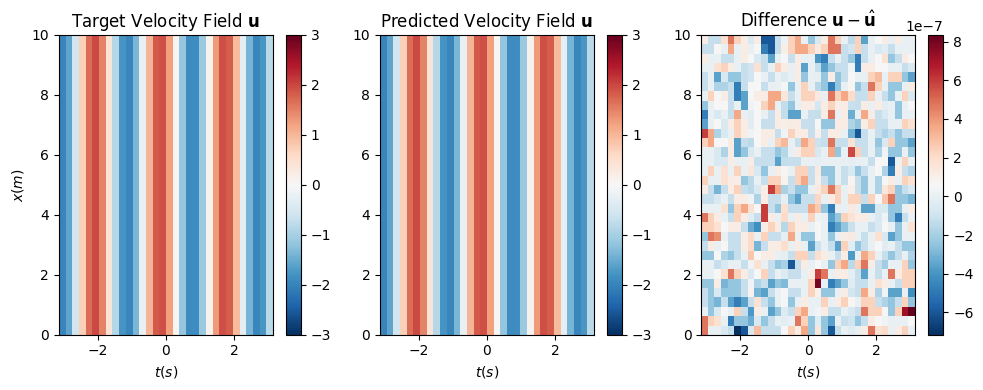

In [62]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)

plt.imshow(test_targets[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='nearest',vmin=-3, vmax=3)
plt.colorbar()
plt.xlabel('$t(s)$')
plt.ylabel('$x(m)$')
plt.title('Target Velocity Field $\\mathbf{u}$')

plt.subplot(1, 3, 2)
plt.imshow(test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='nearest',vmin=-3, vmax=3)
plt.colorbar()
plt.xlabel('$t(s)$')
plt.title('Predicted Velocity Field $\\mathbf{u}$')

plt.subplot(1, 3, 3)
plt.imshow(test_targets[0].squeeze() - test_predictions[0].squeeze(), extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='nearest')
plt.xlabel('$t(s)$')
plt.colorbar()
plt.title('Difference $\\mathbf{u} - \\hat{\\mathbf{u}}$')


plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.tight_layout()
# plt.savefig('result/velocity_field.png', dpi=300)
plt.show()



#### 计算误差

In [82]:
qqq = mean_squared_error(test_targets[0].squeeze(), test_predictions[0].squeeze())
dff= root_mean_squared_error(test_targets[0].squeeze(), test_predictions[0].squeeze()) 
qqq,dff

((4.1708986524974234e-14, 1.0), (2.042277809823488e-07, 0.9999999991991068))

In [80]:
target_image = test_targets[0].squeeze().astype(np.uint8)
predicted_image = test_predictions[0].squeeze().astype(np.uint8)

In [86]:
psnr_value = peak_signal_noise_ratio(target_image, predicted_image)
print(f"PSNR: {psnr_value}")

PSNR: inf


In [90]:
calculate_ssim(target_image, predicted_image)

1.0

In [70]:
test_targets[0].squeeze().shape,test_predictions[0].squeeze().shape

((32, 32), (32, 32))

In [63]:
aCopy = a_predictions[0].squeeze().copy()
bCopy = b_predictions[0].squeeze().copy()
cCopy = c_predictions[0].squeeze().copy()
dCopy = d_predictions[0].squeeze().copy()

aCopy.shape, bCopy.shape, cCopy.shape, dCopy.shape

((32, 32), (32, 32), (32, 32), (32, 32))

In [58]:
np.save('aCopy717.npy', aCopy)
np.save('bCopy717.npy', bCopy)
np.save('cCopy717.npy', cCopy)
np.save('dCopy717.npy', dCopy)

In [59]:
aCopy = np.load("aCopy717.npy")
bCopy = np.load("bCopy717.npy")
cCopy = np.load("cCopy717.npy")
dCopy = np.load("dCopy717.npy")

超分辨过程

## 传统算法

In [128]:
from scipy.ndimage import zoom

In [129]:
# 定义一个函数进行双三次插值
def bicubic_interpolation(data, scale_factor):
    return zoom(data, scale_factor, order=3)


In [130]:
aCopy = np.load("aCopy717.npy")
bCopy = np.load("bCopy717.npy")
cCopy = np.load("cCopy717.npy")
dCopy = np.load("dCopy717.npy")

In [131]:
# 设置放大因子
scale_factor = 4

# 对每组数据进行双三次插值
a_high_res = bicubic_interpolation(aCopy, scale_factor)
b_high_res = bicubic_interpolation(bCopy, scale_factor)
c_high_res = bicubic_interpolation(cCopy, scale_factor)
d_high_res = bicubic_interpolation(dCopy, scale_factor)


In [132]:
# 确认高分辨率数据的形状
print("a_high_res shape:", a_high_res.shape)
print("b_high_res shape:", b_high_res.shape)
print("c_high_res shape:", c_high_res.shape)
print("d_high_res shape:", d_high_res.shape)


a_high_res shape: (128, 128)
b_high_res shape: (128, 128)
c_high_res shape: (128, 128)
d_high_res shape: (128, 128)


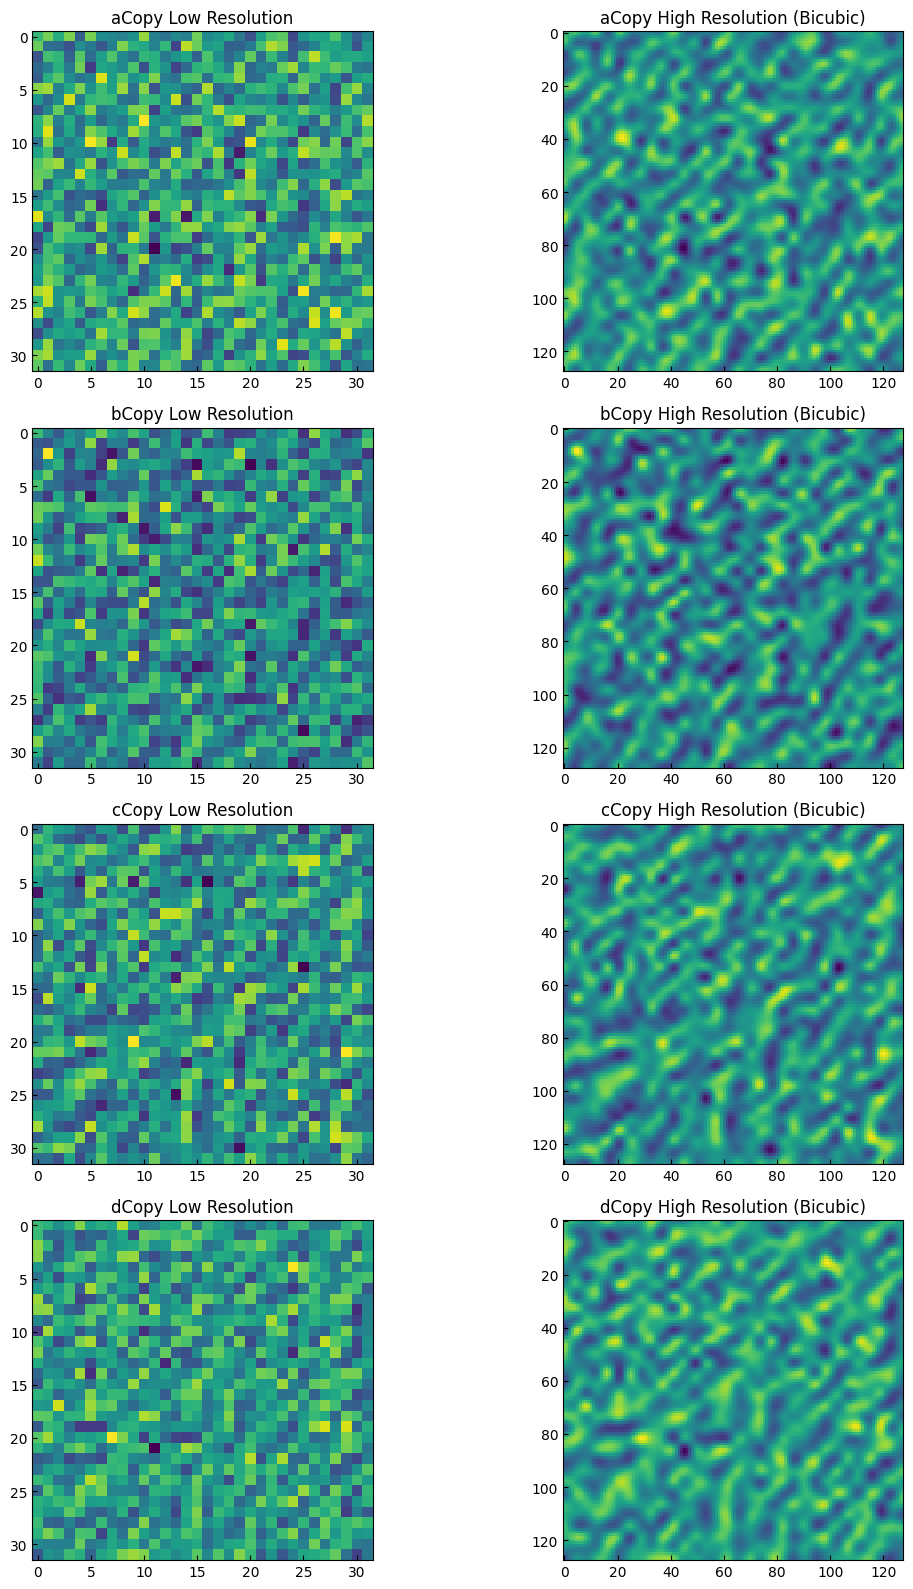

In [133]:
# 可视化对比
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# 绘制原始低分辨率图像
axs[0, 0].imshow(aCopy, cmap='viridis', interpolation='none')
axs[0, 0].set_title('aCopy Low Resolution')
axs[1, 0].imshow(bCopy, cmap='viridis', interpolation='none')
axs[1, 0].set_title('bCopy Low Resolution')
axs[2, 0].imshow(cCopy, cmap='viridis', interpolation='none')
axs[2, 0].set_title('cCopy Low Resolution')
axs[3, 0].imshow(dCopy, cmap='viridis', interpolation='none')
axs[3, 0].set_title('dCopy Low Resolution')

# 绘制双三次插值后的高分辨率图像
axs[0, 1].imshow(a_high_res, cmap='viridis', interpolation='none')
axs[0, 1].set_title('aCopy High Resolution (Bicubic)')
axs[1, 1].imshow(b_high_res, cmap='viridis', interpolation='none')
axs[1, 1].set_title('bCopy High Resolution (Bicubic)')
axs[2, 1].imshow(c_high_res, cmap='viridis', interpolation='none')
axs[2, 1].set_title('cCopy High Resolution (Bicubic)')
axs[3, 1].imshow(d_high_res, cmap='viridis', interpolation='none')
axs[3, 1].set_title('dCopy High Resolution (Bicubic)')

plt.tight_layout()
plt.show()

In [134]:
a_high_res.shape, b_high_res.shape, c_high_res.shape, d_high_res.shape

((128, 128), (128, 128), (128, 128), (128, 128))

In [135]:
sizeLow = 32
xlow = np.linspace(-np.pi, np.pi, sizeLow)
tlow = np.linspace(0, 10, sizeLow)
dxLow = xlow[1] - xlow[0]

sizehigh = 128
xHigh = np.linspace(-np.pi, np.pi, sizehigh)
tHigh = np.linspace(0, 10, sizehigh)
dxHigh = xHigh[1] - xHigh[0]

In [136]:
u_low = compute_u(aCopy, bCopy, cCopy, dCopy, dxLow)


u_high = compute_u(a_high_res, b_high_res, c_high_res, d_high_res, dxHigh)

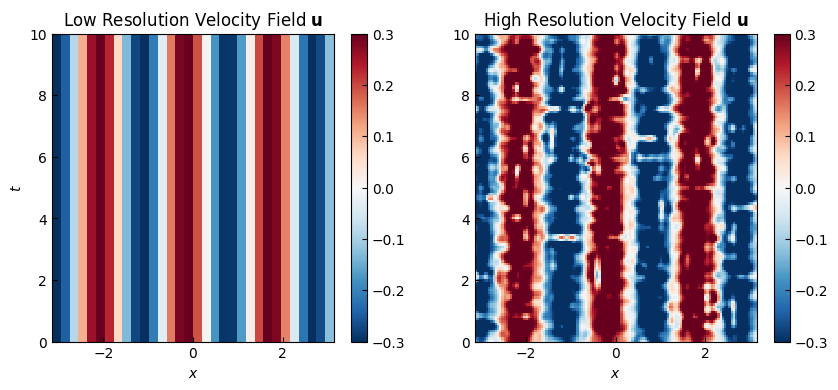

In [137]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(u_low, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.title('Low Resolution Velocity Field $\\mathbf{u}$')

plt.subplot(1, 2, 2)
plt.imshow(u_high, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.xlabel('$x$')
plt.title('High Resolution Velocity Field $\\mathbf{u}$')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.savefig('result/velocity_field_One_High', dpi=300)

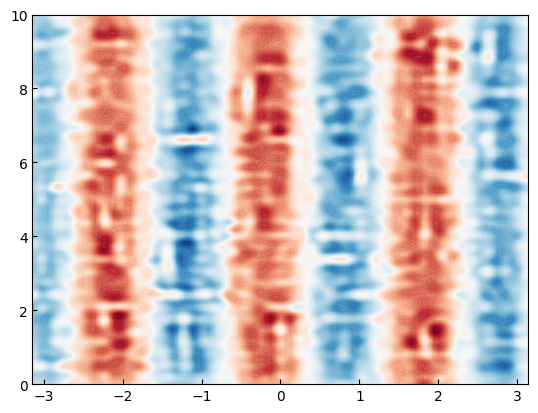

In [138]:
# plt.imshow(u_high, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.contourf(xHigh, tHigh, u_high, 100, cmap='RdBu_r', alpha=0.9)
# plt.savefig('result/velocity_field_high_res.png', dpi=300)

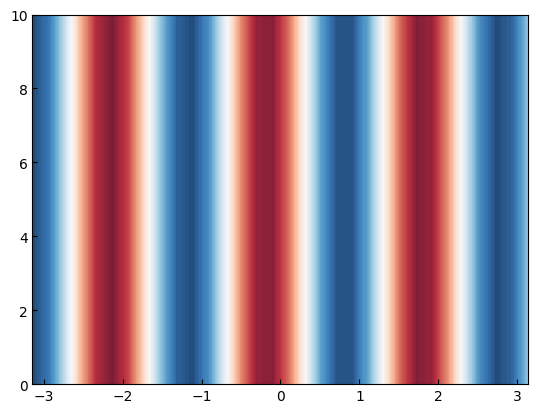

In [139]:
# plt.imshow(u_low, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.contourf(xlow, tlow, u_low, 100, cmap='RdBu_r', alpha=0.9)
# plt.savefig('result/velocity_field_low_res.png', dpi=300)

#### 一维计算误差

In [140]:
u_low.shape, u_high.shape

((32, 32), (128, 128))

In [141]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim

def resize_image(image, target_shape):
    return cv2.resize(image, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_LINEAR)

def calculate_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

def calculate_psnr(image1, image2):
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')
    MAX = 255.0 if image1.dtype == np.uint8 else 1.0
    return 10 * np.log10(MAX**2 / mse)

def calculate_ssim(image1, image2):
    data_range = image1.max() - image1.min()
    return ssim(image1, image2, data_range=data_range)

# 示例图像
u_low = np.random.rand(32, 32)  # 低分辨率图像
u_high = np.random.rand(128, 128)  # 高分辨率图像（超分辨后的图像）

# 调整 u_low 的尺寸到 u_high 的尺寸
u_low_resized = resize_image(u_low, u_high.shape)

# 计算 MSE
mse_value = calculate_mse(u_low_resized, u_high)
print("MSE:", mse_value)

# 计算 PSNR
psnr_value = calculate_psnr(u_low_resized, u_high)
print("PSNR:", psnr_value)

# 计算 SSIM
ssim_value = calculate_ssim(u_low_resized, u_high)
print("SSIM:", ssim_value)


MSE: 0.11877142158376253
PSNR: 9.252880453948597
SSIM: 0.007877081194251161


#### 直接使用bicubic

In [142]:
scale_factor = 4

In [143]:
u_high_bicubic = bicubic_interpolation(u_low, scale_factor)

(128, 128)

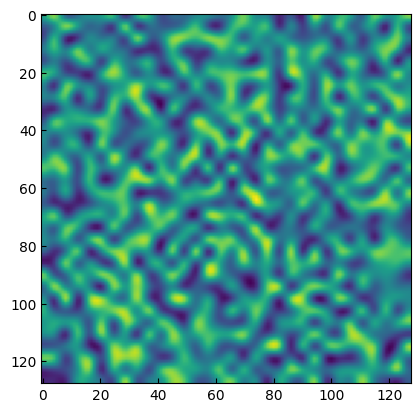

In [145]:
plt.imshow(u_high_bicubic)
u_high_bicubic.shape

In [146]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim

def resize_image(image, target_shape):
    return cv2.resize(image, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_LINEAR)

def calculate_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

def calculate_psnr(image1, image2):
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')
    MAX = 255.0 if image1.dtype == np.uint8 else 1.0
    return 10 * np.log10(MAX**2 / mse)

def calculate_ssim(image1, image2):
    data_range = image1.max() - image1.min()
    return ssim(image1, image2, data_range=data_range)


# 调整 u_low 的尺寸到 u_high 的尺寸
u_low_resized = resize_image(u_low, u_high_bicubic.shape)

# 计算 MSE
mse_value = calculate_mse(u_low_resized, u_high_bicubic)
print("MSE:", mse_value)

# 计算 PSNR
psnr_value = calculate_psnr(u_low_resized, u_high_bicubic)
print("PSNR:", psnr_value)

# 计算 SSIM
ssim_value = calculate_ssim(u_low_resized, u_high_bicubic)
print("SSIM:", ssim_value)


MSE: 0.015855005387505575
PSNR: 17.99833606064294
SSIM: 0.7625405775880877


a_high_res shape: (128, 128)
b_high_res shape: (128, 128)
c_high_res shape: (128, 128)
d_high_res shape: (128, 128)


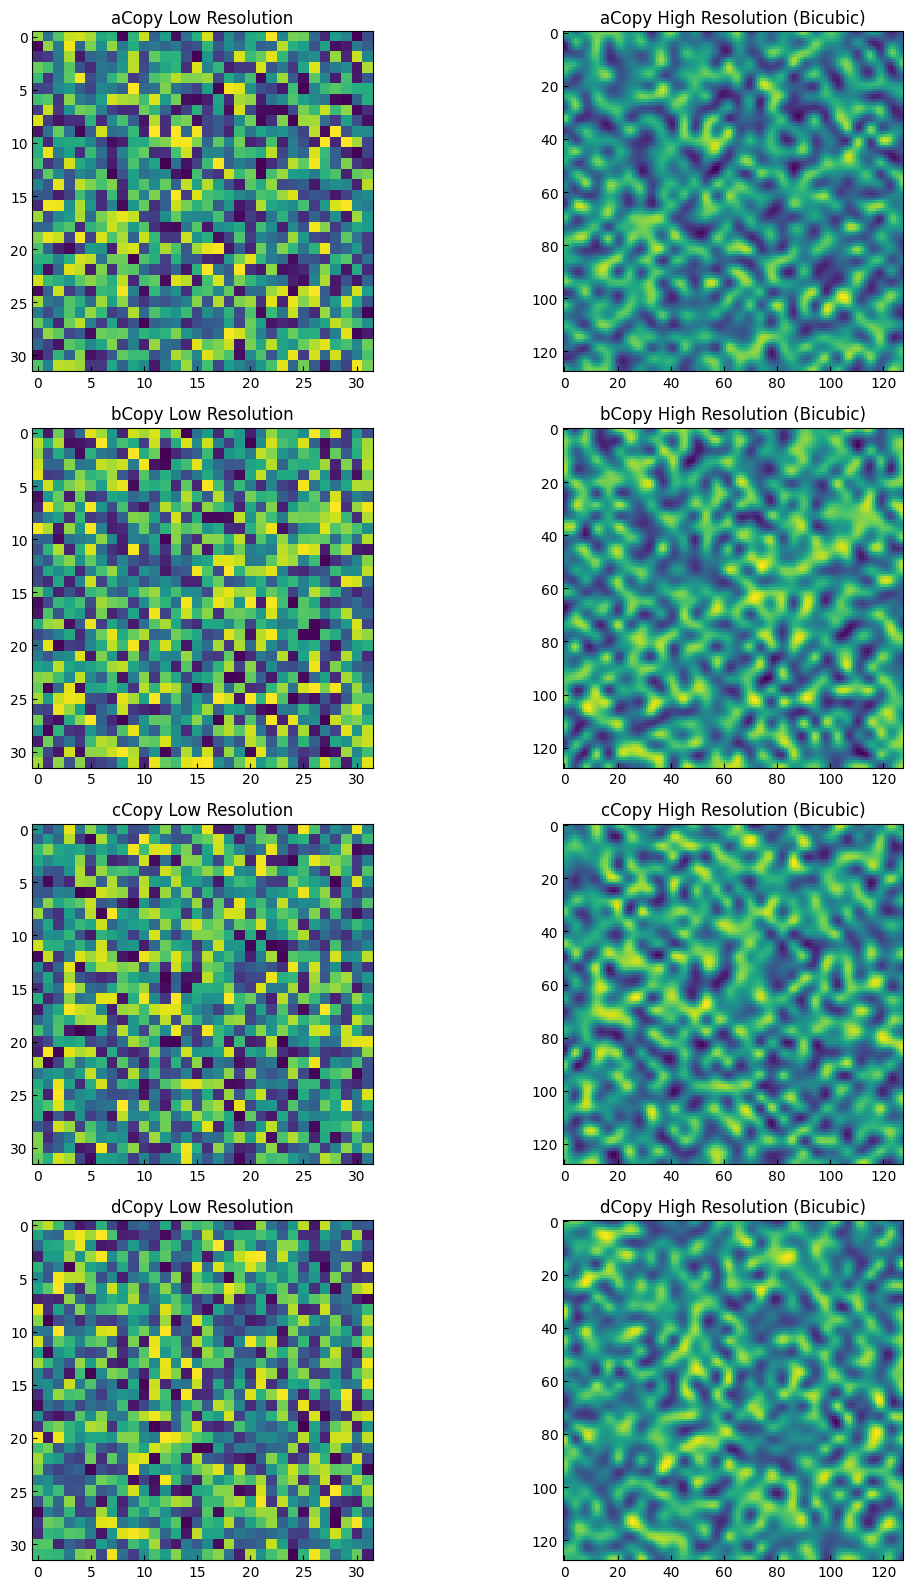

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# 示例数据
aCopy = np.random.rand(32, 32)
bCopy = np.random.rand(32, 32)
cCopy = np.random.rand(32, 32)
dCopy = np.random.rand(32, 32)

# 定义一个函数进行双三次插值
def bicubic_interpolation(data, scale_factor):
    return zoom(data, scale_factor, order=3)

# 设置放大因子
scale_factor = 4

# 对每组数据进行双三次插值
a_high_res = bicubic_interpolation(aCopy, scale_factor)
b_high_res = bicubic_interpolation(bCopy, scale_factor)
c_high_res = bicubic_interpolation(cCopy, scale_factor)
d_high_res = bicubic_interpolation(dCopy, scale_factor)

# 确认高分辨率数据的形状
print("a_high_res shape:", a_high_res.shape)
print("b_high_res shape:", b_high_res.shape)
print("c_high_res shape:", c_high_res.shape)
print("d_high_res shape:", d_high_res.shape)

# 可视化对比
fig, axs = plt.subplots(4, 2, figsize=(12, 16))

# 绘制原始低分辨率图像
axs[0, 0].imshow(aCopy, cmap='viridis', interpolation='none')
axs[0, 0].set_title('aCopy Low Resolution')
axs[1, 0].imshow(bCopy, cmap='viridis', interpolation='none')
axs[1, 0].set_title('bCopy Low Resolution')
axs[2, 0].imshow(cCopy, cmap='viridis', interpolation='none')
axs[2, 0].set_title('cCopy Low Resolution')
axs[3, 0].imshow(dCopy, cmap='viridis', interpolation='none')
axs[3, 0].set_title('dCopy Low Resolution')

# 绘制双三次插值后的高分辨率图像
axs[0, 1].imshow(a_high_res, cmap='viridis', interpolation='none')
axs[0, 1].set_title('aCopy High Resolution (Bicubic)')
axs[1, 1].imshow(b_high_res, cmap='viridis', interpolation='none')
axs[1, 1].set_title('bCopy High Resolution (Bicubic)')
axs[2, 1].imshow(c_high_res, cmap='viridis', interpolation='none')
axs[2, 1].set_title('cCopy High Resolution (Bicubic)')
axs[3, 1].imshow(d_high_res, cmap='viridis', interpolation='none')
axs[3, 1].set_title('dCopy High Resolution (Bicubic)')

plt.tight_layout()
plt.show()


## AI 算法

### SRCNN

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# 定义数据集类
class ABCDFieldDataset(Dataset):
    def __init__(self, low_res_data):
        self.low_res_data = low_res_data

    def __len__(self):
        return len(self.low_res_data)

    def __getitem__(self, idx):
        return self.low_res_data[idx]

准备低分辨率数据
aCopy = a_predictions[0].squeeze().copy()
bCopy = b_predictions[0].squeeze().copy()
cCopy = c_predictions[0].squeeze().copy()
dCopy = d_predictions[0].squeeze().copy()

low_res_data = np.stack([aCopy, bCopy, cCopy, dCopy], axis=0)

# 创建 DataLoader
batch_size = 1
train_dataset = ABCDFieldDataset(torch.tensor(low_res_data).unsqueeze(1).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [21]:
# 定义一个简单的超分辨率CNN模型
class SRCNN(nn.Module):
    def __init__(self, upscale_factor):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=5, padding=2)
        self.upsample = nn.ConvTranspose2d(64, 64, kernel_size=upscale_factor, stride=upscale_factor, padding=0)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.upsample(x)
        x = self.conv3(x)
        return x

In [23]:
# 初始化模型、损失函数和优化器
upscale_factor = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SRCNN(upscale_factor).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)


In [34]:
# 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for low_res in train_loader:
        low_res = low_res.to(device)
        high_res = torch.nn.functional.interpolate(low_res, scale_factor=upscale_factor, mode='bilinear', align_corners=False)

        optimizer.zero_grad()
        outputs = model(low_res)
        loss = criterion(outputs, high_res)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * low_res.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    scheduler.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


Epoch 1/1000, Loss: 0.0001
Epoch 2/1000, Loss: 0.0001
Epoch 3/1000, Loss: 0.0001
Epoch 4/1000, Loss: 0.0001
Epoch 5/1000, Loss: 0.0001
Epoch 6/1000, Loss: 0.0001
Epoch 7/1000, Loss: 0.0001
Epoch 8/1000, Loss: 0.0001
Epoch 9/1000, Loss: 0.0001
Epoch 10/1000, Loss: 0.0001
Epoch 11/1000, Loss: 0.0001
Epoch 12/1000, Loss: 0.0001
Epoch 13/1000, Loss: 0.0001
Epoch 14/1000, Loss: 0.0001
Epoch 15/1000, Loss: 0.0001
Epoch 16/1000, Loss: 0.0001
Epoch 17/1000, Loss: 0.0001
Epoch 18/1000, Loss: 0.0001
Epoch 19/1000, Loss: 0.0001
Epoch 20/1000, Loss: 0.0001
Epoch 21/1000, Loss: 0.0001
Epoch 22/1000, Loss: 0.0001
Epoch 23/1000, Loss: 0.0001
Epoch 24/1000, Loss: 0.0001
Epoch 25/1000, Loss: 0.0001
Epoch 26/1000, Loss: 0.0001
Epoch 27/1000, Loss: 0.0001
Epoch 28/1000, Loss: 0.0001
Epoch 29/1000, Loss: 0.0001
Epoch 30/1000, Loss: 0.0001
Epoch 31/1000, Loss: 0.0001
Epoch 32/1000, Loss: 0.0001
Epoch 33/1000, Loss: 0.0001
Epoch 34/1000, Loss: 0.0001
Epoch 35/1000, Loss: 0.0001
Epoch 36/1000, Loss: 0.0001
E

In [35]:
# 测试模型
model.eval()
with torch.no_grad():
    low_res_sample = torch.tensor(low_res_data).unsqueeze(1).float().to(device)
    output_sample = model(low_res_sample).cpu().numpy()

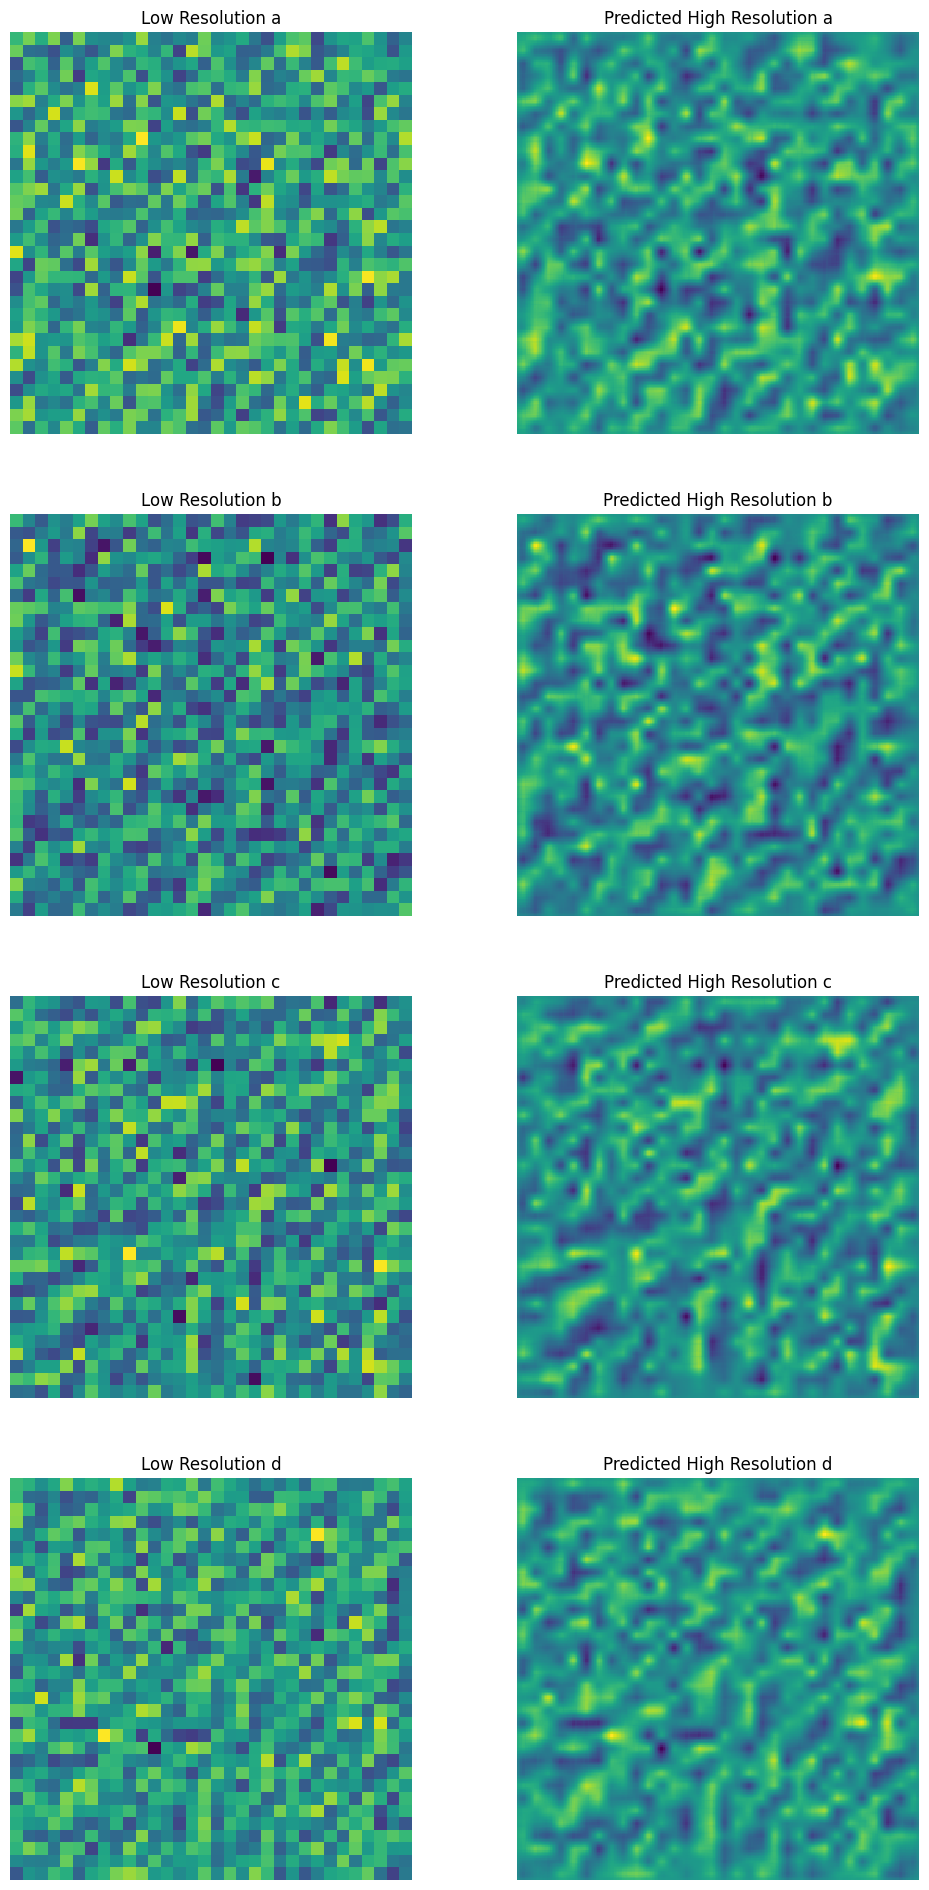

In [36]:
# 可视化结果
fig, axs = plt.subplots(4, 2, figsize=(12, 24))

fields = ['a', 'b', 'c', 'd']
for i in range(4):
    axs[i, 0].imshow(low_res_data[i], cmap='viridis', interpolation='nearest')
    axs[i, 0].set_title(f'Low Resolution {fields[i]}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(output_sample[i][0], cmap='viridis', interpolation='nearest')
    axs[i, 1].set_title(f'Predicted High Resolution {fields[i]}')
    axs[i, 1].axis('off')

plt.show()

In [37]:
a_high_res = output_sample[0][0]
b_high_res = output_sample[1][0]
c_high_res = output_sample[2][0]
d_high_res = output_sample[3][0]

a_high_res.shape, b_high_res.shape, c_high_res.shape, d_high_res.shape

((256, 256), (256, 256), (256, 256), (256, 256))

In [38]:
sizeLow = 32
xlow = np.linspace(-np.pi, np.pi, sizeLow)
tlow = np.linspace(0, 10, sizeLow)
dxLow = xlow[1] - xlow[0]

sizehigh = 256
xHigh = np.linspace(-np.pi, np.pi, sizehigh)
tHigh = np.linspace(0, 10, sizehigh)
dxHigh = xHigh[1] - xHigh[0]

In [39]:
u_low = compute_u(aCopy, bCopy, cCopy, dCopy, dxLow)

a_high = output_sample[0, 0]
b_high = output_sample[1, 0]
c_high = output_sample[2, 0]
d_high = output_sample[3, 0]

u_high = compute_u(a_high_res, b_high_res, c_high_res, d_high_res, dxHigh)


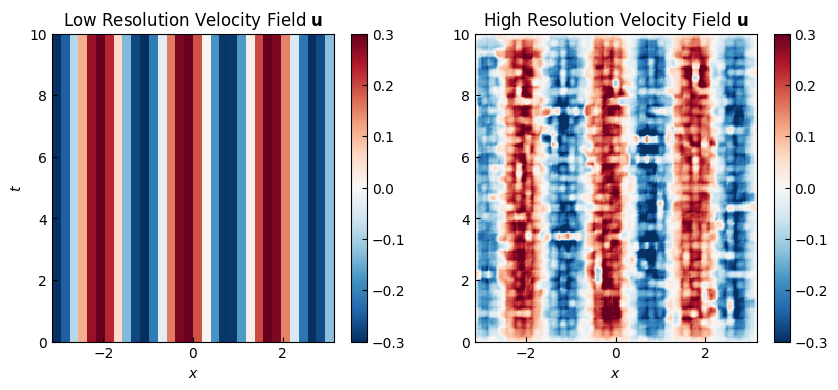

In [51]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(u_low, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.title('Low Resolution Velocity Field $\\mathbf{u}$')

plt.subplot(1, 2, 2)
plt.imshow(u_high, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='RdBu_r', interpolation='none',vmin=-0.3, vmax=0.3)
plt.colorbar()
plt.xlabel('$x$')
plt.title('High Resolution Velocity Field $\\mathbf{u}$')

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

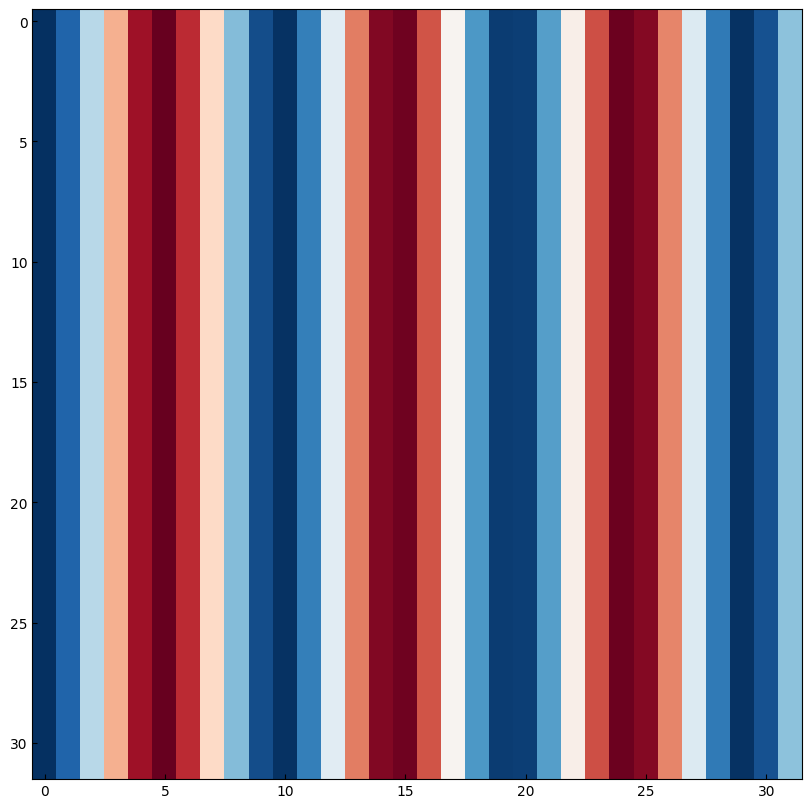

In [53]:
plt.figure(figsize=(10, 10))
plt.imshow(u_low, interpolation='none', cmap='RdBu_r')

In [54]:
u_low.shape

(32, 32)

### ClycleGan

In [1]:
import paddle as pd
import paddle.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
aCopy = np.load("aCopy717.npy")
bCopy = np.load("bCopy717.npy")
cCopy = np.load("cCopy717.npy")
dCopy = np.load("dCopy717.npy")

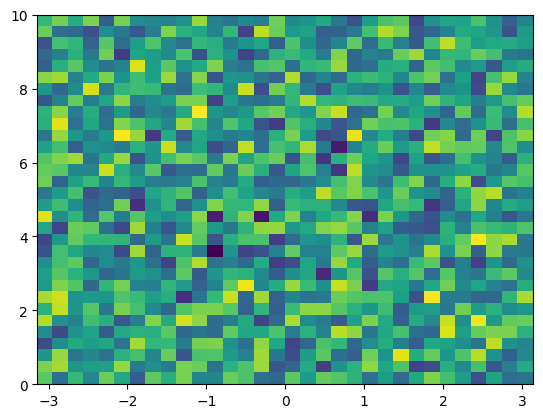

In [6]:
plt.imshow(aCopy, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')

In [13]:
aCopy

array([[ 0.06015105,  0.12759589,  0.03761138, ..., -0.02071459,
        -0.12401037, -0.05144067],
       [ 0.11713569, -0.09538069, -0.10238245, ..., -0.01125342,
        -0.15365916, -0.00621982],
       [-0.15474495,  0.08036683,  0.05674074, ...,  0.02958925,
         0.0343495 ,  0.00968266],
       ...,
       [-0.01099912,  0.15470052, -0.08156231, ..., -0.02412529,
        -0.1257666 , -0.03673694],
       [ 0.13199848,  0.16611508, -0.01669646, ..., -0.14590739,
        -0.06455505,  0.03498148],
       [ 0.10453318, -0.09580866,  0.06299143, ...,  0.0172102 ,
        -0.09753132, -0.08616719]], dtype=float32)

In [14]:
# 定义生成器模型
class GeneratorG(nn.Layer):
    def __init__(self):
        super(GeneratorG, self).__init__()
        self.conv1 = nn.Conv2D(1, 64, 9, padding=4)
        self.conv2 = nn.Conv2D(64, 32, 5, padding=2)
        self.upsample = nn.Conv2DTranspose(32, 32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2D(32, 1, 5, padding=2)

    def forward(self, x):
        x = paddle.nn.functional.relu(self.conv1(x))
        x = paddle.nn.functional.relu(self.conv2(x))
        x = paddle.nn.functional.relu(self.upsample(x))
        x = self.conv3(x)
        return x


In [15]:
# 初始化模型
genG = GeneratorG()

# 加载预训练模型权重
model_path = "saved_models/genG.pdparams"
genG.set_state_dict(paddle.load(model_path))
genG.eval()

# 加载低分辨率数据
aCopy = np.load("aCopy717.npy")
bCopy = np.load("bCopy717.npy")
cCopy = np.load("cCopy717.npy")
dCopy = np.load("dCopy717.npy")


In [17]:
low_res_data = np.stack([aCopy, bCopy, cCopy, dCopy], axis=0)
low_res_data = paddle.to_tensor(low_res_data).astype('float32').unsqueeze(1)  # 添加通道维度


In [22]:
with paddle.no_grad():
    high_res_data = genG(low_res_data)

# 确认输出尺寸是否正确
print(high_res_data.shape)



[4, 1, 64, 64]


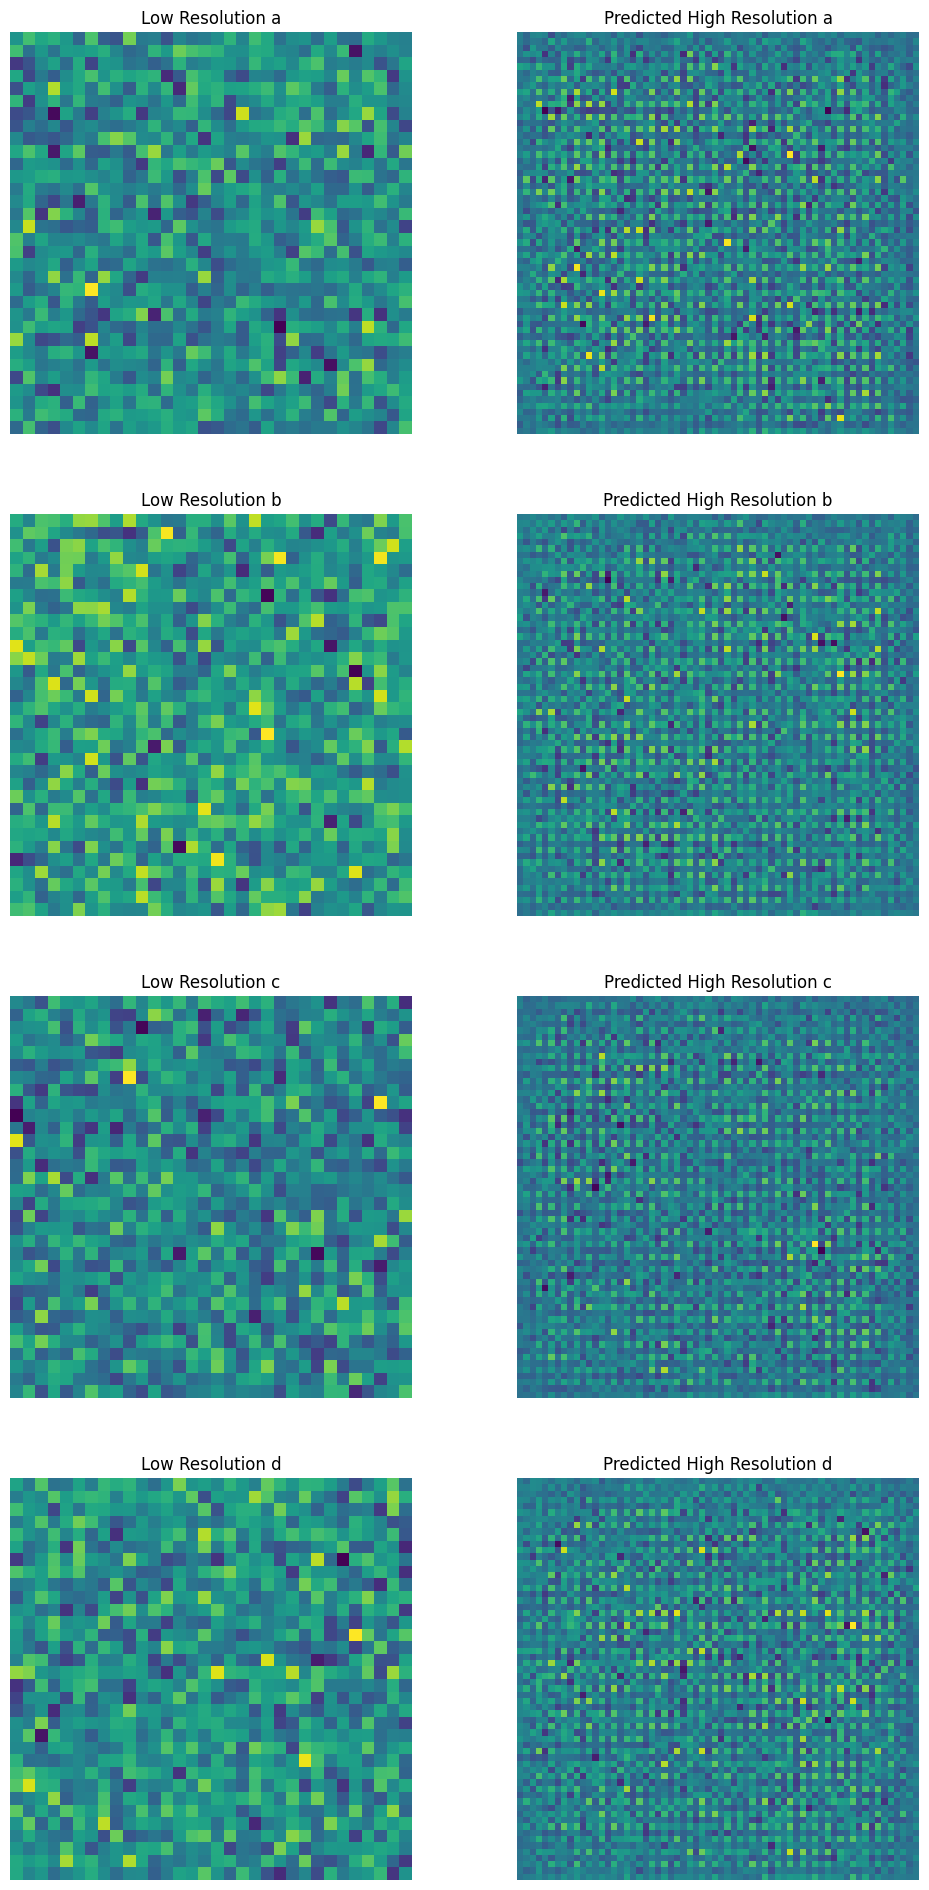

In [23]:
# 可视化结果
high_res_data = high_res_data.numpy()

fig, axs = plt.subplots(4, 2, figsize=(12, 24))

fields = ['a', 'b', 'c', 'd']
for i in range(4):
    axs[i, 0].imshow(low_res_data[i, 0], cmap='viridis', interpolation='nearest')
    axs[i, 0].set_title(f'Low Resolution {fields[i]}')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(high_res_data[i, 0], cmap='viridis', interpolation='nearest')
    axs[i, 1].set_title(f'Predicted High Resolution {fields[i]}')
    axs[i, 1].axis('off')

plt.show()

In [25]:
sizeLow = 32
xlow = np.linspace(-np.pi, np.pi, sizeLow)
tlow = np.linspace(0, 10, sizeLow)
dxLow = xlow[1] - xlow[0]

sizehigh = 64
xHigh = np.linspace(-np.pi, np.pi, sizehigh)
tHigh = np.linspace(0, 10, sizehigh)
dxHigh = xHigh[1] - xHigh[0]

In [26]:
u_low = compute_u(aCopy, bCopy, cCopy, dCopy, dxLow)
1
a_high = high_res_data[0, 0]
b_high = high_res_data[1, 0]
c_high = high_res_data[2, 0]
d_high = high_res_data[3, 0]

u_high = compute_u(a_high, b_high, c_high, d_high, dxHigh)


ValueError: operands could not be broadcast together with shapes (64,64) (32,32) 

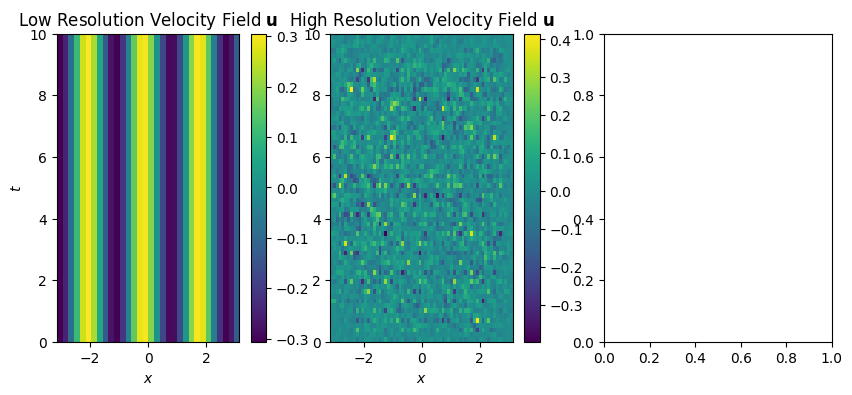

In [27]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(u_low, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$t$')

plt.title('Low Resolution Velocity Field $\\mathbf{u}$')

plt.subplot(1, 3, 2)
plt.imshow(u_high, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel('$x$')
plt.title('High Resolution Velocity Field $\\mathbf{u}$')

plt.subplot(1, 3, 3)
plt.imshow(u_high - u_low, extent=(-np.pi, np.pi, 0, 10), aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel('$x$')
plt.title('Difference $\\mathbf{u}_{high} - \\mathbf{u}_{low}$')

plt.tight_layout()
plt.show()


# 二维算例

In [12]:
import numpy as np
import matplotlib.pyplot as plt


In [13]:
# 定义常数
hbar = 1

# 定义 H(x)
def H(x):
    return np.where((0 <= x) & (x <= np.pi), x / 2, np.pi - x / 2)

# 定义函数 a, b, c, d
def a(x, y):
    return np.cos(H(x)) * np.cos(np.cos(y) * (2 - np.cos(x)) / hbar)

def b(x, y):
    return np.cos(H(x)) * np.sin(np.cos(y) * (2 - np.cos(x)) / hbar)

def c(x, y):
    return np.sin(H(x)) * np.cos(np.cos(y) * (2 + np.cos(x)) / hbar)

def d(x, y):
    return -np.sin(H(x)) * np.sin(np.cos(y) * (2 + np.cos(x)) / hbar)

# 计算梯度
def gradient(f, x, y, eps=1e-5):
    f_x = (f(x + eps, y) - f(x - eps, y)) / (2 * eps)
    f_y = (f(x, y + eps) - f(x, y - eps)) / (2 * eps)
    return f_x, f_y

# 计算速度场
def compute_velocity_field_np(x, y, dx, dy):
    # 使用内置的np 求解梯度
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = np.gradient(a_val, dx, dy)
    b_grad_x, b_grad_y = np.gradient(b_val, dx, dy)
    c_grad_x, c_grad_y = np.gradient(c_val, dx, dy)
    d_grad_x, d_grad_y = np.gradient(d_val, dx, dy)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y

def compute_velocity_field_FD(x, y):
    # 有限差分进行计算
    a_val = a(x, y)
    b_val = b(x, y)
    c_val = c(x, y)
    d_val = d(x, y)

    a_grad_x, a_grad_y = gradient(a, x, y)
    b_grad_x, b_grad_y = gradient(b, x, y)
    c_grad_x, c_grad_y = gradient(c, x, y)
    d_grad_x, d_grad_y = gradient(d, x, y)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)

    return u_x, u_y

In [14]:
size = 128
x = np.linspace(0, 2 * np.pi, size)
y = np.linspace(0, 2 * np.pi, size)
X, Y = np.meshgrid(x, y)

In [15]:
# 计算函数值
A = a(X, Y)
B = b(X, Y)
C = c(X, Y)
D = d(X, Y)

In [16]:
# 计算步长
dx = x[1] - x[0]
dy = y[1] - y[0]

In [17]:
U_x, U_y = compute_velocity_field_np(X, Y, dx, dy)

U_x_FD, U_y_FD = compute_velocity_field_FD(X, Y)

# 计算速度场的大小
U_magnitude = np.sqrt(U_x**2 + U_y**2)

U_magnitude_FD = np.sqrt(U_x_FD**2 + U_y_FD**2)

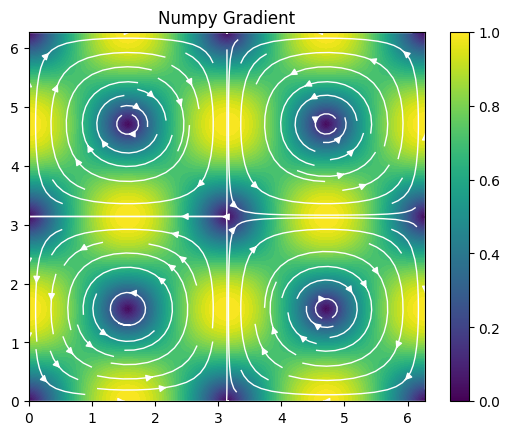

In [18]:
plt.contourf(X, Y, U_magnitude, levels=50, cmap='viridis')
# plt.streamplot(X, Y, U_x, U_y, color='white', linewidth=1)
plt.title('Numpy Gradient')
plt.streamplot(X, Y, U_x_FD, U_y_FD, color='white', linewidth=1)
plt.xlim(0, 2 * np.pi)
plt.ylim(0, 2 * np.pi)
plt.colorbar()


In [19]:
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy

In [20]:
# 计算旋度
vort = vorticity(U_x, U_y, dx, dy)
vort_FD = vorticity(U_x_FD, U_y_FD, dx, dy)

# 归一化旋度
max_vort = np.max(np.abs(vort))
vort_normalized = vort / max_vort if max_vort != 0 else vort

max_vort_FD = np.max(np.abs(vort_FD))
vort_normalized_FD = vort_FD / max_vort_FD if max_vort_FD != 0 else vort_FD


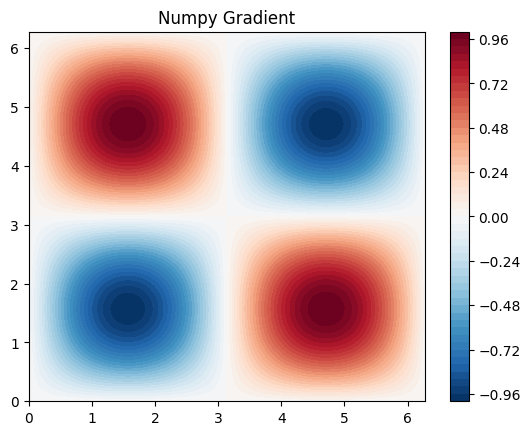

In [21]:

plt.contourf(X, Y, vort_normalized, levels=50, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Numpy Gradient')
plt.colorbar()

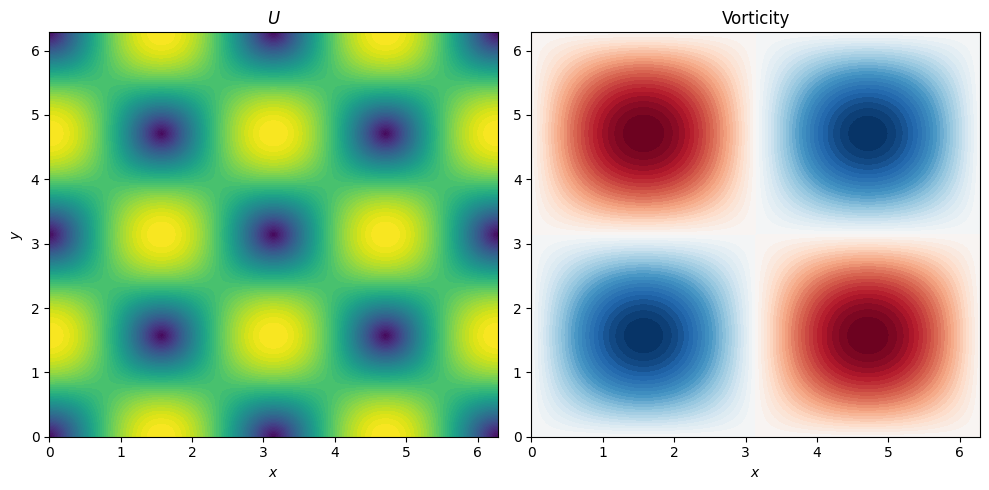

In [22]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)

plt.contourf(X, Y, U_magnitude, levels=50, cmap='viridis')
# plt.streamplot(X, Y, U_x, U_y, color='white', linewidth=1)
plt.title('$U$')
# plt.streamplot(X, Y, U_x_FD, U_y_FD, color='white', linewidth=1)
plt.xlim(0, 2 * np.pi)
plt.ylim(0, 2 * np.pi)
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.subplot(1, 2, 2)
plt.contourf(X, Y, vort_normalized, levels=50, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Vorticity')
plt.xlabel('$x$')

plt.tight_layout()
# plt.savefig('result/velocity_field_vorticity.png', dpi=500)
plt.show()




### modelA

In [32]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [33]:
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [25]:
# 将数据转换为PyTorch张量
U_x = torch.tensor(U_x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # 增加batch和channel维度
U_y = torch.tensor(U_y, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_magnitude = torch.tensor(U_magnitude, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# 合并速度场作为输入
velocity_field = torch.cat((U_x, U_y, U_magnitude), dim=1)

# 目标abcd (假设为0初始化)
target_abcd = torch.zeros((1, 4, size, size), dtype=torch.float32)

# 创建数据集和数据加载器
dataset = TensorDataset(velocity_field, target_abcd)
dataloader = DataLoader(dataset, batch_size=500, shuffle=True)

In [26]:
# class ModelA(nn.Module):
#     def __init__(self):
#         super(ModelA, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
#         self.bn2 = nn.BatchNorm2d(128)
#         self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
#         self.bn3 = nn.BatchNorm2d(256)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
#         self.bn4 = nn.BatchNorm2d(512)
#         self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
#         self.conv5 = nn.Conv2d(512, 4, kernel_size=3, padding=1)

#     def forward(self, x):
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = self.pool(x)
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = self.pool(x)
#         x = F.relu(self.bn3(self.conv3(x)))
#         x = self.pool(x)
#         x = F.relu(self.bn4(self.conv4(x)))
#         x = self.upsample(x)  # 使用上采样恢复到原始尺寸
#         x = self.conv5(x)
#         return x

class BasicModelA(nn.Module):
    def __init__(self):
        super(BasicModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.conv5 = nn.Conv2d(512, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.upsample(x)  # 使用上采样恢复到原始尺寸
        x = self.conv5(x)
        return x

class ConstraintLayer(nn.Module):
    def __init__(self):
        super(ConstraintLayer, self).__init__()

    def forward(self, x):
        # 假设x的形状为 [batch_size, 4, height, width]，其中4代表abcd
        norm = torch.sqrt(x[:, 0, :, :]**2 + x[:, 1, :, :]**2 + x[:, 2, :, :]**2 + x[:, 3, :, :]**2 + 1e-8)
        norm = norm.unsqueeze(1)  # 为了与abcd的四个通道对齐
        x = x / norm  # 归一化
        return x
    

class ModelAWithConstraints(nn.Module):
    def __init__(self):
        super(ModelAWithConstraints, self).__init__()
        self.model = BasicModelA()
        self.constraint_layer = ConstraintLayer()

    def forward(self, x):
        x = self.model(x)
        x = self.constraint_layer(x)
        return x


#### 传统 loss function
这里的loss function我们进行了修改

In [ ]:
# 定义损失函数
# 这个 loss function 比较基础，没有考虑数学和物理相关知识。
def loss_function(predicted_abcd, true_velocity, epsilon):
    # 提取 a, b, c, d
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]

    # 根据 a, b, c, d 计算预测的速度场
    U_x_pred = a + b
    U_y_pred = c + d
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    # 计算速度场的损失
    U_x_true = true_velocity[:, 0, :, :]
    U_y_true = true_velocity[:, 1, :, :]
    U_magnitude_true = true_velocity[:, 2, :, :]
    
    loss_velocity = F.mse_loss(U_x_pred, U_x_true) + F.mse_loss(U_y_pred, U_y_true) + F.mse_loss(U_magnitude_pred, U_magnitude_true)
    
    # 计算正则化项
    regularization_term = epsilon * (torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    # 总损失
    total_loss = loss_velocity + regularization_term
    return total_loss


#### 考虑数学和物理约束的loss function

In [27]:
def calculate_gradients_with_numpy(tensor):
    # 确保 Tensor 不需要梯度跟踪，且在 CPU 上
    tensor_np = tensor.detach().cpu().numpy()

   
    # 计算梯度
    grad_x = np.gradient(tensor_np, axis=1)  # 假设水平方向是 axis=1
    grad_y = np.gradient(tensor_np, axis=2)  # 假设垂直方向是 axis=2
    
    # 转换回 Tensor
    grad_x_tensor = torch.from_numpy(grad_x).to(tensor.device)
    grad_y_tensor = torch.from_numpy(grad_y).to(tensor.device)
    
    return grad_x_tensor, grad_y_tensor


In [28]:
def laplacian_2d(array, dx, dy):
    grad_x = np.gradient(array, dx, axis=1, edge_order=2)  # 计算 x 方向的一阶导数
    grad_y = np.gradient(array, dy, axis=0, edge_order=2)  # 计算 y 方向的一阶导数
    
    laplacian_x = np.gradient(grad_x, dx, axis=1, edge_order=2)  # 计算 x 方向的二阶导数
    laplacian_y = np.gradient(grad_y, dy, axis=0, edge_order=2)  # 计算 y 方向的二阶导数
    
    return laplacian_x + laplacian_y


def laplacian_2d_torch(tensor, dx, dy):
    # 确保tensor是浮点类型，因为梯度计算通常需要浮点运算
    tensor = tensor.float()
    tensor_np = tensor.detach().cpu().numpy()

    # 计算x和y方向的一阶导数
    grad_x = np.gradient(tensor_np, axis=1)  # x方向
    grad_y = np.gradient(tensor_np, axis=2)  # y方向

    # 计算x和y方向的二阶导数
    laplacian_x = np.gradient(grad_x, axis=1)
    laplacian_y = np.gradient(grad_y, axis=2)

    laplacian_x_tensor = torch.from_numpy(laplacian_x).to(tensor.device)
    laplacian_y_tensor = torch.from_numpy(laplacian_y).to(tensor.device)

    # 相加得到完整的拉普拉斯算子
    laplacian = laplacian_x_tensor + laplacian_y_tensor

    return laplacian



In [29]:
# # 简单测试一下正确性
# import numpy as np
# import matplotlib.pyplot as plt


# # 设置
# x = np.linspace(0, 10, 100)
# y = np.linspace(0, 10, 100)
# xx, yy = np.meshgrid(x, y)
# array = np.sin(xx) + np.cos(yy)

# # 计算拉普拉斯的正确步长
# dx = dy = (10 - 0) / (100 - 1)
# laplacian_calculated = laplacian_2d(array, dx, dy)
# correct_laplacian = -np.sin(xx) - np.cos(yy)

# # 可视化比较
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 3, 1)
# plt.imshow(correct_laplacian, extent=(0, 10, 0, 10), origin='lower')
# plt.colorbar()
# plt.title('Correct Laplacian')

# plt.subplot(1, 3, 2)
# plt.imshow(laplacian_calculated, extent=(0, 10, 0, 10), origin='lower')
# plt.colorbar()
# plt.title('Calculated Laplacian')

# plt.subplot(1, 3, 3)
# plt.imshow(laplacian_calculated - correct_laplacian, extent=(0, 10, 0, 10), origin='lower')
# plt.colorbar()
# plt.title('Difference')

# plt.show()


In [30]:
# 定义损失函数
# 这个 loss function 考虑了数学和物理约束
def loss_function(predicted_abcd, true_velocity, epsilon):
    # 提取 a, b, c, d
    # 提取 a, b, c, d，并增加批次维度以兼容梯度计算
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]
    # print(a.shape)
    
    # 计算梯度
    a_grad_x, a_grad_y = calculate_gradients_with_numpy(a)
    b_grad_x, b_grad_y = calculate_gradients_with_numpy(b)
    c_grad_x, c_grad_y = calculate_gradients_with_numpy(c)
    d_grad_x, d_grad_y = calculate_gradients_with_numpy(d)

    hbar = 1  # 你可以根据具体情况调整这个参数


        # 根据 a, b, c, d 计算预测的速度场
    U_x_pred = a + b
    U_y_pred = c + d
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    # 计算速度场的损失
    U_x_true = true_velocity[:, 0, :, :]
    U_y_true = true_velocity[:, 1, :, :]
    U_magnitude_true = true_velocity[:, 2, :, :]


    # U_x_pred = hbar * (a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x)
    # U_y_pred = hbar * (a * b_grad_y - b * a_grad_y + c * d_grad_y - d * c_grad_y)
    # U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    # # # 计算速度场的损失
    # U_x_true = true_velocity[:, 0, :, :]
    # U_y_true = true_velocity[:, 1, :, :]
    # U_magnitude_true = true_velocity[:, 2, :, :]


    loss_velocity =  F.mse_loss(U_magnitude_pred, U_magnitude_true)+F.mse_loss(U_x_pred, U_x_true) + F.mse_loss(U_y_pred, U_y_true) 
    
    # 计算归一化约束
    # psi1 = a + 1j * b
    # psi2 = c + 1j * d
    norm = a**2 + b**2 + c**2 + d**2

    
    norm_constraint = F.mse_loss(norm, torch.ones_like(norm))

    #     # 计算拉普拉斯算子
    lap_b = laplacian_2d_torch(b, dx,dy)
    lap_a = laplacian_2d_torch(a, dx,dy)
    lap_d = laplacian_2d_torch(d, dx,dy)
    lap_c = laplacian_2d_torch(c, dx,dy)

    # # 计算螺旋度约束

    curl_constraint = (a * lap_b - b * lap_a + c * lap_d - d * lap_c).sum()
    
    # # 计算正则化项
    regularization_term = epsilon * 0.25*(torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    # # 总损失
    total_loss = loss_velocity #+ norm_constraint + curl_constraint #+ regularization_term 
    return total_loss

In [31]:
# 超参数
learning_rate = 0.001
num_epochs = 10000
epsilon = 0.01

channels = 3

# 创建模型和优化器
model = ModelAWithConstraints()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [32]:
def plot_comparison(predicted, actual, step):
    
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]
    
    a_grad_x, a_grad_y = calculate_gradients_with_numpy(a)
    b_grad_x, b_grad_y = calculate_gradients_with_numpy(b)
    c_grad_x, c_grad_y = calculate_gradients_with_numpy(c)
    d_grad_x, d_grad_y = calculate_gradients_with_numpy(d)

    hbar = 1

    U_x_pred = hbar * (a * b_grad_x - b * a_grad_x + c * d_grad_x - d * c_grad_x)
    U_y_pred = hbar * (a * b_grad_y - b * a_grad_y + c * d_grad_y - d * c_grad_y)
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)

    
    
    plt.subplots(2, 3, figsize=(10, 8))

    plt.subplot(2, 3, 1)
    plt.imshow(U_magnitude_pred[0].detach().cpu().numpy(), cmap='viridis')

    plt.title('Predicted Magnitude')

    plt.subplot(2, 3, 2)
    plt.imshow(U_x_pred[0].detach().cpu().numpy(), cmap='viridis')
    plt.title('Predicted U_x')

    plt.subplot(2, 3, 3)
    plt.imshow(U_y_pred[0].detach().cpu().numpy(), cmap='viridis')
    plt.title('Predicted U_y')

    plt.subplot(2, 3, 4)
    plt.imshow(actual[0,2].detach().cpu().numpy(), cmap='viridis')
    plt.title('Actual Magnitude')

    plt.subplot(2, 3, 5)
    plt.imshow(actual[0,1].detach().cpu().numpy(), cmap='viridis'   )
    plt.title('Actual U_x')

    plt.subplot(2, 3, 6)
    plt.imshow(actual[0,0].detach().cpu().numpy(), cmap='viridis')
    plt.title('Actual U_y')

    plt.suptitle(f'Step {step}')
    plt.show()


In [33]:
# 训练模型
for epoch in range(num_epochs):
    for i, (velocity, _) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_abcd = model(velocity)
        loss = loss_function(predicted_abcd, velocity, epsilon)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')



Epoch [1/10000], Step [1], Loss: 1.3357
Epoch [2/10000], Step [1], Loss: 0.8080
Epoch [3/10000], Step [1], Loss: 0.4882
Epoch [4/10000], Step [1], Loss: 0.2901
Epoch [5/10000], Step [1], Loss: 0.1404
Epoch [6/10000], Step [1], Loss: 0.0804
Epoch [7/10000], Step [1], Loss: 0.0583
Epoch [8/10000], Step [1], Loss: 0.0537
Epoch [9/10000], Step [1], Loss: 0.0560
Epoch [10/10000], Step [1], Loss: 0.0595
Epoch [11/10000], Step [1], Loss: 0.0619
Epoch [12/10000], Step [1], Loss: 0.0626
Epoch [13/10000], Step [1], Loss: 0.0617
Epoch [14/10000], Step [1], Loss: 0.0596
Epoch [15/10000], Step [1], Loss: 0.0566
Epoch [16/10000], Step [1], Loss: 0.0531
Epoch [17/10000], Step [1], Loss: 0.0492
Epoch [18/10000], Step [1], Loss: 0.0451
Epoch [19/10000], Step [1], Loss: 0.0412
Epoch [20/10000], Step [1], Loss: 0.0376
Epoch [21/10000], Step [1], Loss: 0.0343
Epoch [22/10000], Step [1], Loss: 0.0315
Epoch [23/10000], Step [1], Loss: 0.0292
Epoch [24/10000], Step [1], Loss: 0.0273
Epoch [25/10000], Step [1

In [34]:
# 测试数据生成
U_x_test, U_y_test = compute_velocity_field_np(X, Y, dx, dy)
U_magnitude_test = np.sqrt(U_x_test**2 + U_y_test**2)

# 将测试数据转换为PyTorch张量
U_x_test = torch.tensor(U_x_test, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_y_test = torch.tensor(U_y_test, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_magnitude_test = torch.tensor(U_magnitude_test, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# 合并测试速度场作为输入
velocity_field_test = torch.cat((U_x_test, U_y_test, U_magnitude_test), dim=1)

# 将模型设置为评估模式
model.eval()

# 使用测试数据进行预测
with torch.no_grad():
    predicted_abcd_test = model(velocity_field_test)

# 打印预测结果
print("Predicted a, b, c, d:")
print(predicted_abcd_test)

# 计算预测的速度场
a_test = predicted_abcd_test[:, 0, :, :].squeeze().numpy()
b_test = predicted_abcd_test[:, 1, :, :].squeeze().numpy()
c_test = predicted_abcd_test[:, 2, :, :].squeeze().numpy()
d_test = predicted_abcd_test[:, 3, :, :].squeeze().numpy()

U_x_pred_test = a_test + b_test
U_y_pred_test = c_test + d_test
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)

Predicted a, b, c, d:
tensor([[[[-0.4050, -0.4191, -0.4205,  ..., -0.4933, -0.5002, -0.5061],
          [-0.4181, -0.4343, -0.4337,  ..., -0.5103, -0.5158, -0.5237],
          [-0.4434, -0.4569, -0.4539,  ..., -0.5362, -0.5398, -0.5459],
          ...,
          [-0.3735, -0.3869, -0.3869,  ..., -0.4454, -0.4452, -0.4501],
          [-0.4070, -0.4220, -0.4230,  ..., -0.4827, -0.4825, -0.4876],
          [-0.4288, -0.4450, -0.4470,  ..., -0.5048, -0.5054, -0.5125]],

         [[ 0.3799,  0.3942,  0.3956,  ...,  0.4687,  0.4753,  0.4812],
          [ 0.3691,  0.3842,  0.3840,  ...,  0.4609,  0.4662,  0.4738],
          [ 0.3445,  0.3572,  0.3549,  ...,  0.4376,  0.4405,  0.4470],
          ...,
          [ 0.4718,  0.4858,  0.4852,  ...,  0.5435,  0.5440,  0.5487],
          [ 0.4561,  0.4716,  0.4723,  ...,  0.5324,  0.5325,  0.5374],
          [ 0.4528,  0.4695,  0.4713,  ...,  0.5293,  0.5300,  0.5369]],

         [[ 0.5997,  0.6021,  0.6244,  ...,  0.4660,  0.4864,  0.4934],
        

In [35]:
velocity_field_test.shape

torch.Size([1, 3, 128, 128])

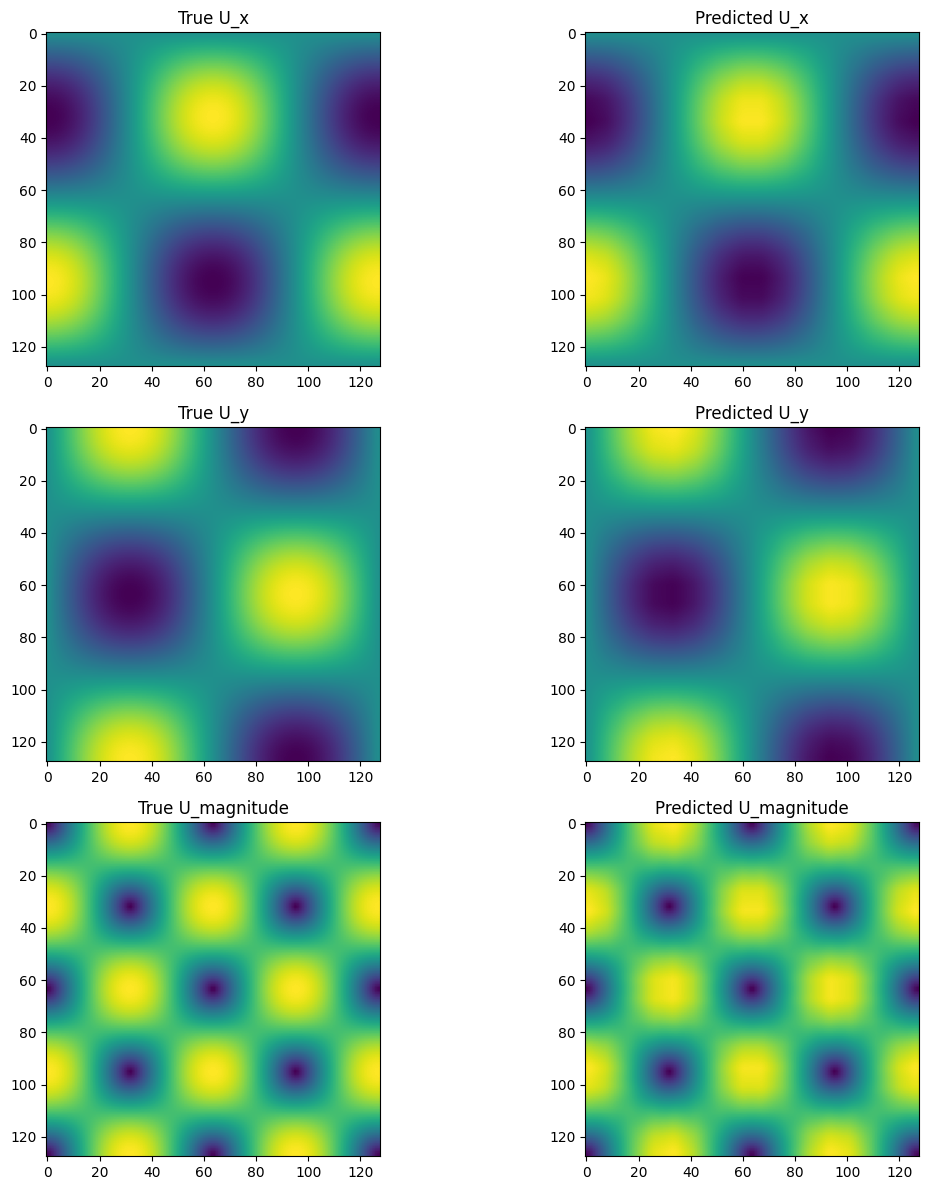

In [36]:
# 绘图
fig, axes = plt.subplots(3, 2, figsize=(12, 12))

# U_x
axes[0, 0].imshow(U_x_test.squeeze().numpy(), cmap='viridis')
axes[0, 0].set_title('True U_x')
axes[0, 1].imshow(U_x_pred_test, cmap='viridis')
axes[0, 1].set_title('Predicted U_x')

# U_y
axes[1, 0].imshow(U_y_test.squeeze().numpy(), cmap='viridis')
axes[1, 0].set_title('True U_y')
axes[1, 1].imshow(U_y_pred_test, cmap='viridis')
axes[1, 1].set_title('Predicted U_y')

# U_magnitude
axes[2, 0].imshow(U_magnitude_test.squeeze().numpy(), cmap='viridis')
axes[2, 0].set_title('True U_magnitude')
axes[2, 1].imshow(U_magnitude_pred_test, cmap='viridis')
axes[2, 1].set_title('Predicted U_magnitude')

plt.tight_layout()
plt.show()


In [46]:
mean_squared_error(U_magnitude_pred_test,U_magnitude_test.squeeze().numpy())

(9.073023080843002e-06, 0.9999999998604687)

In [47]:
root_mean_squared_error(U_magnitude_pred_test,U_magnitude_test.squeeze().numpy())

(0.003012145926219877, 0.9999881876630344)

In [37]:
vort_pred = vorticity(U_x_pred_test, U_y_pred_test, dx, dy)
max_vort_pred = np.max(np.abs(vort_pred))
vort_pred_normalized = vort_pred / max_vort_pred if max_vort_pred != 0 else vort_pred



In [38]:
U_magnitude_test.shape

torch.Size([1, 1, 128, 128])

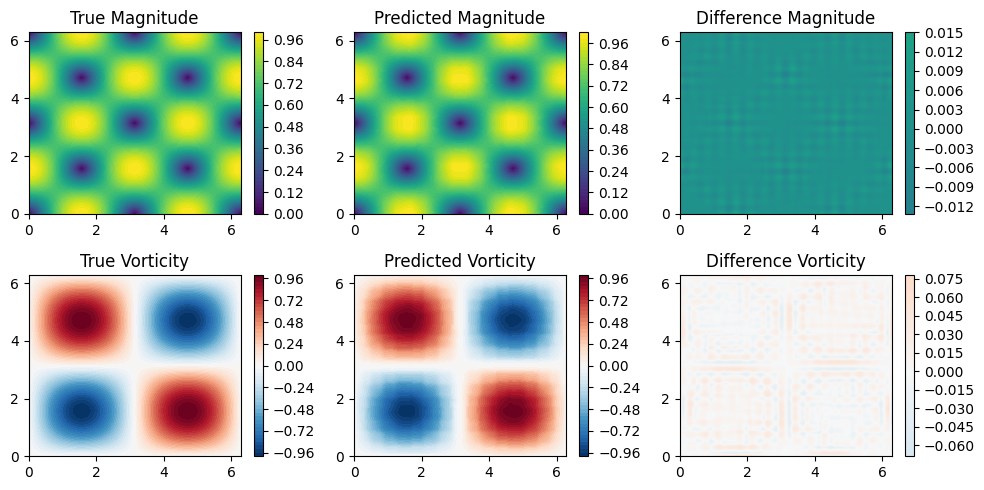

In [39]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 3, 2)
plt.contourf(X, Y, U_magnitude_pred_test, levels=50, cmap='viridis', vmin=0, vmax=1)
plt.title('Predicted Magnitude')
plt.colorbar()

plt.subplot(2, 3, 1)
plt.contourf(X, Y, U_magnitude_test[0,0], levels=50, cmap='viridis', vmin=0, vmax=1)
plt.title('True Magnitude')
plt.colorbar()

plt.subplot(2, 3, 3)
plt.contourf(X, Y, U_magnitude_pred_test - U_magnitude_test.squeeze().numpy(), levels=50, cmap='viridis', vmin=-0.1, vmax=0.1)
plt.title('Difference Magnitude')
plt.colorbar()



plt.subplot(2, 3, 5)
plt.contourf(X, Y, vort_pred_normalized, levels=50, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('Predicted Vorticity')
plt.colorbar()

plt.subplot(2, 3, 4)
plt.contourf(X, Y, vort_normalized, levels=50, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('True Vorticity')
plt.colorbar()

plt.subplot(2, 3, 6)
plt.contourf(X, Y, vort_pred_normalized - vort_normalized, levels=50, cmap='RdBu_r', vmin=-0.4, vmax=0.4)
plt.title('Difference Vorticity')
plt.colorbar()



plt.tight_layout()
# plt.savefig('result/velocity_field_vorticity_result.png', dpi=500)
plt.show()



In [92]:
def get_image_range(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return min_val, max_val

In [95]:
def calculate_ssim(image1, image2):
    # 如果图像是彩色的，先将它们转换为灰度图像
    if len(image1.shape) == 3:
        image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    if len(image2.shape) == 3:
        image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    # 获取图像范围
    min_val1, max_val1 = get_image_range(image1)
    min_val2, max_val2 = get_image_range(image2)
    
    # 计算SSIM
    data_range = max(max_val1, max_val2) - min(min_val1, min_val2)
    ssim_value, _ = ssim(image1, image2, full=True, data_range=data_range)
    return ssim_value


In [98]:
U_magnitude_pred_test111  = U_magnitude_test[0,0].numpy()

In [101]:
U_magnitude_pred_test22222 = U_magnitude_pred_test.astype(np.uint8)

U_magnitude_pred_test1112222 = U_magnitude_pred_test111.astype(np.uint8)

In [102]:
peak_signal_noise_ratio(U_magnitude_pred_test22222,U_magnitude_pred_test1112222)

74.7119779939636

In [99]:
calculate_ssim(U_magnitude_pred_test,U_magnitude_pred_test111)

0.9974768757860175

In [104]:
# 计算真实的a, b, c, d值
a_real = a(X, Y)
b_real = b(X, Y)
c_real = c(X, Y)
d_real = d(X, Y)

TypeError: 'Tensor' object is not callable

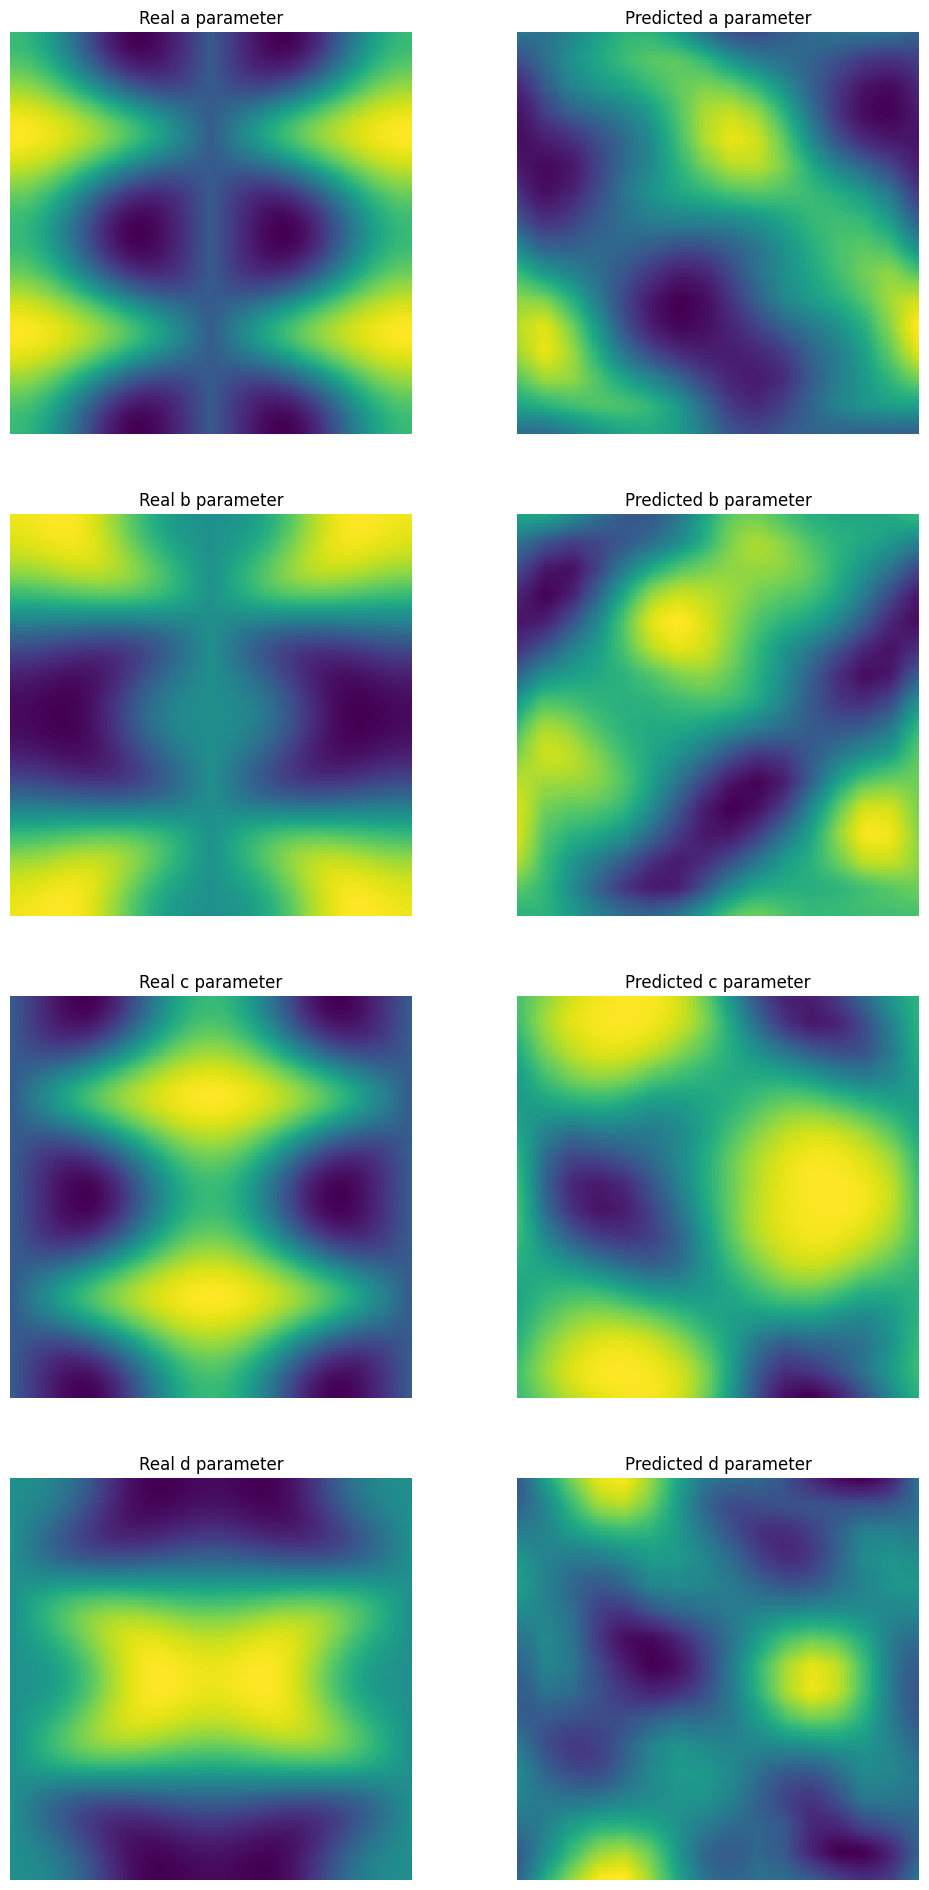

In [105]:
import matplotlib.pyplot as plt

# 创建图形窗口
fig, axs = plt.subplots(4, 2, figsize=(12, 24))

# 可视化真实和预测的a参数
axs[0, 0].imshow(a_real, cmap='viridis')
axs[0, 0].set_title('Real a parameter')
axs[0, 0].axis('off')

axs[0, 1].imshow(a_test, cmap='viridis')
axs[0, 1].set_title('Predicted a parameter')
axs[0, 1].axis('off')

# 可视化真实和预测的b参数
axs[1, 0].imshow(b_real, cmap='viridis')
axs[1, 0].set_title('Real b parameter')
axs[1, 0].axis('off')

axs[1, 1].imshow(b_test, cmap='viridis')
axs[1, 1].set_title('Predicted b parameter')
axs[1, 1].axis('off')

# 可视化真实和预测的c参数
axs[2, 0].imshow(c_real, cmap='viridis')
axs[2, 0].set_title('Real c parameter')
axs[2, 0].axis('off')

axs[2, 1].imshow(c_test, cmap='viridis')
axs[2, 1].set_title('Predicted c parameter')
axs[2, 1].axis('off')

# 可视化真实和预测的d参数
axs[3, 0].imshow(d_real, cmap='viridis')
axs[3, 0].set_title('Real d parameter')
axs[3, 0].axis('off')

axs[3, 1].imshow(d_test, cmap='viridis')
axs[3, 1].set_title('Predicted d parameter')
axs[3, 1].axis('off')

# 显示图形
plt.show()


## Model B

In [106]:
a_test.shape, b_test.shape, c_test.shape, d_test.shape

((128, 128), (128, 128), (128, 128), (128, 128))

In [111]:
# 设置放大因子
scale_factor = 4

# 对每组数据进行双三次插值
a_high_res = bicubic_interpolation(a_test, scale_factor)
b_high_res = bicubic_interpolation(b_test, scale_factor)
c_high_res = bicubic_interpolation(c_test, scale_factor)
d_high_res = bicubic_interpolation(d_test, scale_factor)


In [112]:
# 确认高分辨率数据的形状
print("a_high_res shape:", a_high_res.shape)
print("b_high_res shape:", b_high_res.shape)
print("c_high_res shape:", c_high_res.shape)
print("d_high_res shape:", d_high_res.shape)


a_high_res shape: (512, 512)
b_high_res shape: (512, 512)
c_high_res shape: (512, 512)
d_high_res shape: (512, 512)


In [ ]:
plt.figure(figsize=(16, 16))

plt.subplot(2, 4, 1)
plt.imshow(a_test, cmap='viridis')
plt.title('Low Resolution a')

plt.subplot(2, 4, 2)
plt.imshow(b_test, cmap='viridis')
plt.title('Low Resolution b')

plt.subplot(2, 4, 3)
plt.imshow(c_test, cmap='viridis')
plt.title('Low Resolution c')

plt.subplot(2, 4, 4)
plt.imshow(d_test, cmap='viridis')
plt.title('Low Resolution d')

plt.subplot(2, 4, 5)
plt.imshow(a_high_res, cmap='viridis')
plt.title('High Resolution a')

plt.subplot(2, 4, 6)
plt.imshow(b_high_res, cmap='viridis')
plt.title('High Resolution b')

plt.subplot(2, 4, 7)
plt.imshow(c_high_res, cmap='viridis')
plt.title('High Resolution c')

plt.subplot(2, 4, 8)
plt.imshow(d_high_res, cmap='viridis')
plt.title('High Resolution d')

# 手动调整子图间距
plt.subplots_adjust(wspace=0.4, hspace=0.1)
plt.show()



In [114]:
sizeLow = 128
xlow = np.linspace(0, 2 * np.pi, sizeLow)
tlow = np.linspace(0, 2 * np.pi, sizeLow)
dxLow = xlow[1] - xlow[0]

sizehigh = 512
xHigh = np.linspace(0, 2 * np.pi, sizehigh)
tHigh = np.linspace(0, 2 * np.pi, sizehigh)
dxHigh = xHigh[1] - xHigh[0]

In [115]:
U_x_pred1 = a_high_res + b_high_res
U_y_pred1 = c_high_res + d_high_res
U_magnitude_pred1 = np.sqrt(U_x_pred1**2 + U_y_pred1**2)

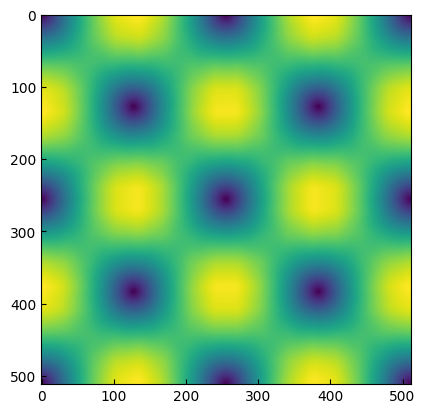

In [116]:
plt.imshow(U_magnitude_pred1, cmap='viridis')

In [117]:
U_x_test1 = a_test + b_test
U_y_test1 = c_test + d_test
U_magnitude_test1 = np.sqrt(U_y_test1**2 + U_x_test1**2)

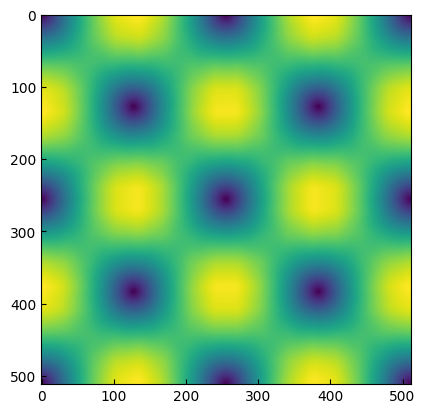

In [118]:
plt.imshow(U_magnitude_pred1, cmap='viridis')

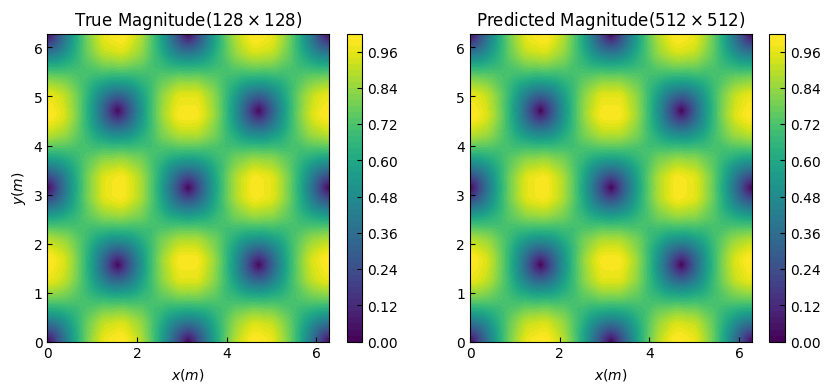

In [119]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.contourf(X, Y, U_magnitude_test1, levels=50, cmap='viridis', vmin=0, vmax=1)
plt.title('True Magnitude$(128\\times128)$')
plt.colorbar()
plt.xlabel('$x(m)$')
plt.ylabel('$y(m)$')


plt.subplot(1, 2, 2)
plt.contourf(xHigh, tHigh, U_magnitude_pred1, levels=50, cmap='viridis', vmin=0, vmax=1)
plt.title('Predicted Magnitude$(512\\times512)$')
plt.colorbar()
plt.xlabel('$x(m)$')


plt.savefig('result/velocity_field_vorticity_result_512.png', dpi=500)
plt.show()



In [120]:
U_magnitude_test1.shape,U_magnitude_pred1.shape

((128, 128), (512, 512))

In [121]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize

In [122]:
U_magnitude_pred1_resized = resize(U_magnitude_pred1, U_magnitude_test1.shape, anti_aliasing=True)


In [123]:
psnr_value = psnr(U_magnitude_test1, U_magnitude_pred1_resized, data_range=1.0)
print(f"PSNR: {psnr_value}")

PSNR: 43.45998100963094


In [124]:
ssim_value, ssim_map = ssim(U_magnitude_test1, U_magnitude_pred1_resized, data_range=1.0, full=True)
print(f"SSIM: {ssim_value}")

SSIM: 0.9992670730112766


In [125]:
mean_squared_error(U_magnitude_test1,U_magnitude_pred1_resized)

(4.508186760665301e-05, 0.9999999993066995)

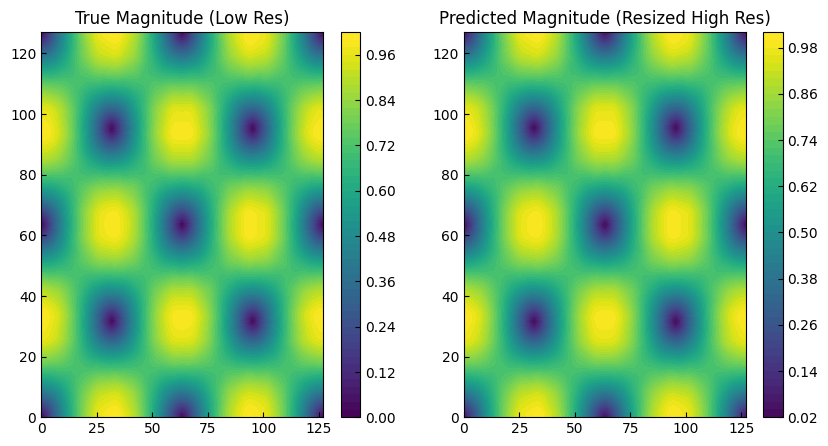

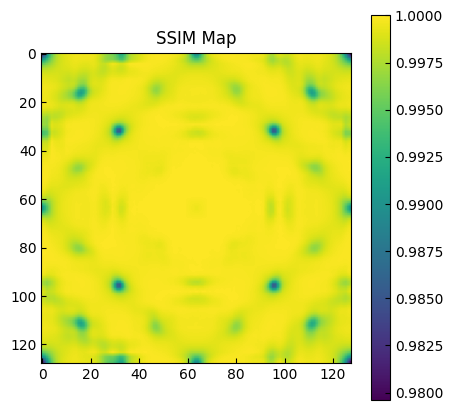

In [212]:
# 可视化
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.contourf(U_magnitude_test1, levels=50, cmap='viridis', vmin=0, vmax=1)
plt.title('True Magnitude (Low Res)')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.contourf(U_magnitude_pred1_resized, levels=50, cmap='viridis', vmin=0, vmax=1)
plt.title('Predicted Magnitude (Resized High Res)')
plt.colorbar()

plt.figure(figsize=(5, 5))
plt.title('SSIM Map')
plt.imshow(ssim_map, cmap='viridis')
plt.colorbar()
plt.show()


#### 直接采用bicubic

In [147]:
U_magnitude_test1.shape

(128, 128)

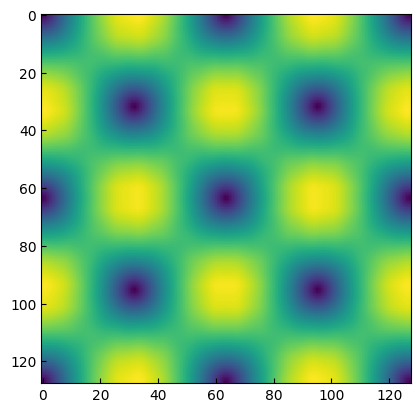

In [151]:
plt.imshow(U_magnitude_test1, cmap='viridis')

In [155]:
scale_factor = 4

In [156]:
u_high_2weidu_bicubic = bicubic_interpolation(U_magnitude_test1, scale_factor)

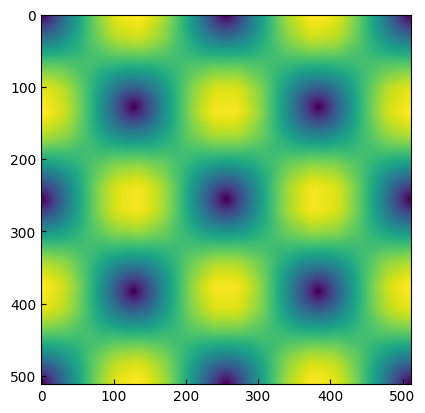

In [157]:
plt.imshow(u_high_2weidu_bicubic, cmap='viridis')

In [159]:
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim

def resize_image(image, target_shape):
    return cv2.resize(image, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_LINEAR)

def calculate_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

def calculate_psnr(image1, image2):
    mse = calculate_mse(image1, image2)
    if mse == 0:
        return float('inf')
    MAX = 255.0 if image1.dtype == np.uint8 else 1.0
    return 10 * np.log10(MAX**2 / mse)

def calculate_ssim(image1, image2):
    data_range = image1.max() - image1.min()
    return ssim(image1, image2, data_range=data_range)


# 调整 u_low 的尺寸到 u_high 的尺寸
u_low_resized = resize_image(u_low, u_high_2weidu_bicubic.shape)

# 计算 MSE
mse_value = calculate_mse(u_low_resized, u_high_2weidu_bicubic)
print("MSE:", mse_value)

# 计算 PSNR
psnr_value = calculate_psnr(u_low_resized, u_high_2weidu_bicubic)
print("PSNR:", psnr_value)

# 计算 SSIM
ssim_value = calculate_ssim(u_low_resized, u_high_2weidu_bicubic)
print("SSIM:", ssim_value)


MSE: 0.11076539299521258
PSNR: 9.555959072868545
SSIM: 0.2496068976355679


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

class BasicModelA(nn.Module):
    def __init__(self):
        super(BasicModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.conv5 = nn.Conv2d(512, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.upsample(x)  # 使用上采样恢复到原始尺寸
        x = self.conv5(x)
        return x

# 定义模型
model = BasicModelA()

# 生成示例输入数据
x = torch.randn(1, 3, 128, 128)

# 生成结构图
y = model(x)
dot = make_dot(y, params=dict(model.named_parameters()))

# 保存为 dot 文件
dot.save('BasicModelA.dot')


'BasicModelA.dot'

# 三维问题

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 定义常数
hbar = 1

def sgn(x):
    return np.sign(x)

def a(x, y, z):
    return np.cos(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.cos((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) - np.cos(x) * np.cos(z))) / hbar)

def b(x, y, z):
    return np.cos(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.sin((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) - np.cos(x) * np.cos(z))) / hbar)

def c(x, y, z):
    return np.sin(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.cos((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) + np.cos(x) * np.cos(z))) / hbar)

def d(x, y, z):
    return -np.sin(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.sin((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) + np.cos(x) * np.cos(z))) / hbar)


In [3]:
def gradient_3d(f, x, y, z, eps=1e-5):
    f_x = (f(x + eps, y, z) - f(x - eps, y, z)) / (2 * eps)
    f_y = (f(x, y + eps, z) - f(x, y - eps, z)) / (2 * eps)
    f_z = (f(x, y, z + eps) - f(x, y, z - eps)) / (2 * eps)
    return f_x, f_y, f_z


In [4]:
def compute_velocity_field_3d_np(x, y, z, dx, dy, dz):
    a_val = a(x, y, z)
    b_val = b(x, y, z)
    c_val = c(x, y, z)
    d_val = d(x, y, z)

    a_grad_x, a_grad_y, a_grad_z = np.gradient(a_val, dx, dy, dz)
    b_grad_x, b_grad_y, b_grad_z = np.gradient(b_val, dx, dy, dz)
    c_grad_x, c_grad_y, c_grad_z = np.gradient(c_val, dx, dy, dz)
    d_grad_x, d_grad_y, d_grad_z = np.gradient(d_val, dx, dy, dz)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)
    u_z = hbar * (a_val * b_grad_z - b_val * a_grad_z + c_val * d_grad_z - d_val * c_grad_z)

    return u_x, u_y, u_z

In [5]:
# 定义网格
size = 128
x = np.linspace(0, 2 * np.pi, size)
y = np.linspace(0, 2 * np.pi, size)
z = np.linspace(0, 2 * np.pi, size)
X, Y, Z = np.meshgrid(x, y, z)


In [6]:
# 计算步长
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]


In [7]:
# 计算速度场
U_x, U_y, U_z = compute_velocity_field_3d_np(X, Y, Z, dx, dy, dz)

# 计算速度场的大小
U_magnitude = np.sqrt(U_x**2 + U_y**2 + U_z**2)

In [8]:
U_magnitude.shape

(128, 128, 128)

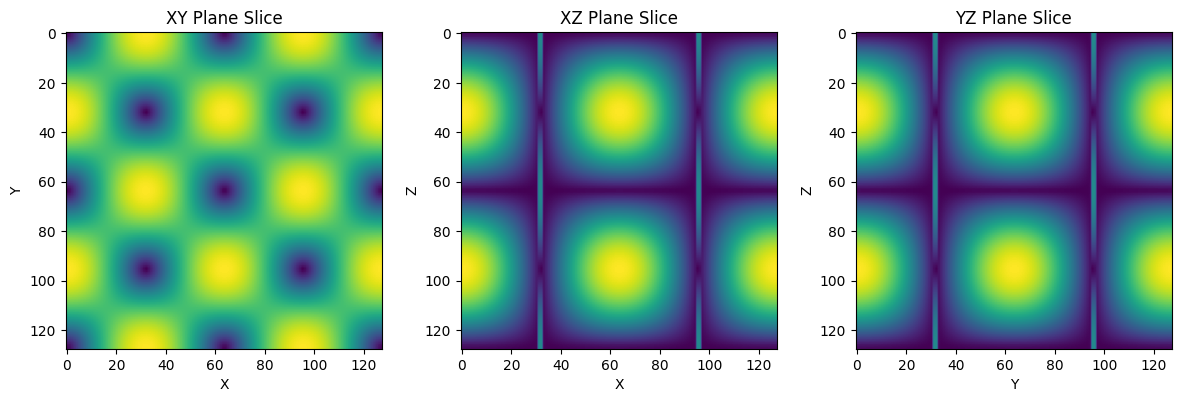

In [9]:
# 可视化切片
fig, axes = plt.subplots(1, 3, figsize=(12, 10))

# 选择一个切片位置
slice_index = size // 2

plt.subplot(1, 3, 1)
# x-y 平面切片
plt.imshow( U_magnitude[:, :, slice_index],  cmap='viridis')
plt.title('XY Plane Slice')
plt.xlabel('X')
plt.ylabel('Y')
# axes[0, 0].streamplot(X[:, :, slice_index], Y[:, :, slice_index], U_x[:, :, slice_index], U_y[:, :, slice_index], color='white')

plt.subplot(1, 3, 2)
# x-z 平面切片
plt.imshow(U_magnitude[:, slice_index, :], cmap='viridis')
plt.title('XZ Plane Slice')
plt.xlabel('X')
plt.ylabel('Z')
# axes[0, 1].streamplot(X[:, slice_index, :], Z[:, slice_index, :], U_x[:, slice_index, :], U_z[:, slice_index, :], color='white')

plt.subplot(1, 3, 3)
# y-z 平面切片
plt.imshow( U_magnitude[slice_index, :, :], cmap='viridis')
plt.title('YZ Plane Slice')
plt.xlabel('Y')
plt.ylabel('Z')
# axes[1, 0].streamplot(Y[slice_index, :, :], Z[slice_index, :, :], U_y[slice_index, :, :], U_z[slice_index, :, :], color='white')


plt.tight_layout()
# plt.savefig('result/velocity_field_3d_slices.png', dpi=500)
plt.show()


In [10]:
U_magnitude[:, 16, :].shape

(128, 128)

In [11]:
# 定义常数
hbar = 1

def sgn(x):
    return np.sign(x)

def a(x, y, z):
    return np.cos(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.cos((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) - np.cos(x) * np.cos(z))) / hbar)

def b(x, y, z):
    return np.cos(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.sin((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) - np.cos(x) * np.cos(z))) / hbar)

def c(x, y, z):
    return np.sin(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.cos((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) + np.cos(x) * np.cos(z))) / hbar)

def d(x, y, z):
    return -np.sin(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.sin((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) + np.cos(x) * np.cos(z))) / hbar)


In [12]:
def compute_velocity_field_3d_np(x, y, z, dx, dy, dz):
    a_val = a(x, y, z)
    b_val = b(x, y, z)
    c_val = c(x, y, z)
    d_val = d(x, y, z)

    a_grad_x, a_grad_y, a_grad_z = np.gradient(a_val, dx, dy, dz)
    b_grad_x, b_grad_y, b_grad_z = np.gradient(b_val, dx, dy, dz)
    c_grad_x, c_grad_y, c_grad_z = np.gradient(c_val, dx, dy, dz)
    d_grad_x, d_grad_y, d_grad_z = np.gradient(d_val, dx, dy, dz)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)
    u_z = hbar * (a_val * b_grad_z - b_val * a_grad_z + c_val * d_grad_z - d_val * c_grad_z)

    return u_x, u_y, u_z


In [13]:
def vorticity_3d(U_x, U_y, U_z, dx, dy, dz):
    dU_y_dz, dU_y_dy, dU_y_dx = np.gradient(U_y, dz, dy, dx)
    dU_z_dz, dU_z_dy, dU_z_dx = np.gradient(U_z, dz, dy, dx)
    dU_x_dz, dU_x_dy, dU_x_dx = np.gradient(U_x, dz, dy, dx)

    omega_x = dU_z_dy - dU_y_dz
    omega_y = dU_x_dz - dU_z_dx
    omega_z = dU_y_dx - dU_x_dy

    return omega_x, omega_y, omega_z

In [14]:
size = 128
x = np.linspace(0, 2 * np.pi, size)
y = np.linspace(0, 2 * np.pi, size)
z = np.linspace(0, 2 * np.pi, size)
X, Y, Z = np.meshgrid(x, y, z)


In [15]:
# 计算步长
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

In [16]:
# 计算速度梯度
U_x_grad_x, U_x_grad_y, U_x_grad_z = np.gradient(U_x, dx, dy, dz)
U_y_grad_x, U_y_grad_y, U_y_grad_z = np.gradient(U_y, dx, dy, dz)
U_z_grad_x, U_z_grad_y, U_z_grad_z = np.gradient(U_z, dx, dy, dz)


In [17]:
# 计算速度场
U_x, U_y, U_z = compute_velocity_field_3d_np(X, Y, Z, dx, dy, dz)


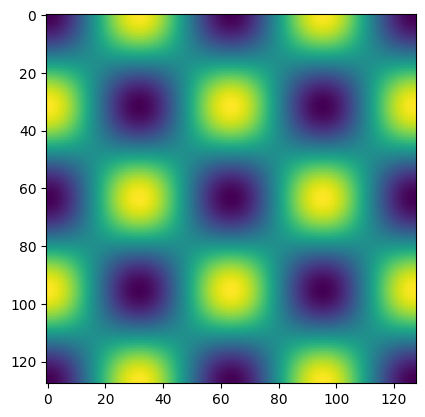

In [18]:
plt.imshow(U_x[:, :, size // 2]**2+U_y[:, :, size // 2]**2, cmap='viridis')

In [19]:
vorticity_x, vorticity_y, vorticity_z = vorticity_3d(U_x, U_y, U_z, dx, dy, dz)

In [20]:
# 归一化涡度场
max_vorticity = np.max(np.sqrt(vorticity_x**2 + vorticity_y**2 + vorticity_z**2))
vorticity_x_normalized = vorticity_x / max_vorticity if max_vorticity != 0 else vorticity_x
vorticity_y_normalized = vorticity_y / max_vorticity if max_vorticity != 0 else vorticity_y
vorticity_z_normalized = vorticity_z / max_vorticity if max_vorticity != 0 else vorticity_z


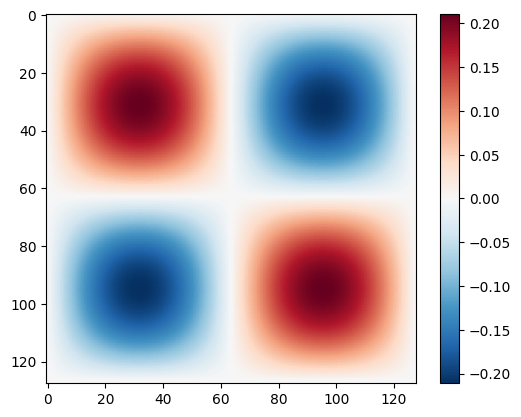

In [21]:
plt.imshow(vorticity_z_normalized[:, :, size // 2], cmap='RdBu_r')
plt.colorbar()

In [22]:
import pyvista as pv

In [23]:
# 创建pyvista网格
grid = pv.StructuredGrid(X, Y, Z)

In [184]:
# 创建一个矢量场数据
vectors = np.zeros((size * size * size, 3))
vectors[:, 0] = U_x.ravel()
vectors[:, 1] = U_y.ravel()
vectors[:, 2] = U_z.ravel()
grid['velocity'] = vectors

In [185]:
# 创建一个归一化后的涡度场数据
vorticity_vectors = np.zeros((size * size * size, 3))
vorticity_vectors[:, 0] = vorticity_x_normalized.ravel()
vorticity_vectors[:, 1] = vorticity_y_normalized.ravel()
vorticity_vectors[:, 2] = vorticity_z_normalized.ravel()
grid['vorticity'] = vorticity_vectors


In [51]:
# 将数据导出为VTK文件
grid.save('velocity_and_vorticity_field.vtk')


In [186]:
import numpy as np
import pyvista as pv

# 定义常数
hbar = 1

def sgn(x):
    return np.sign(x)

def a(x, y, z):
    return np.cos(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.cos((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) - np.cos(x) * np.cos(z))) / hbar)

def b(x, y, z):
    return np.cos(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.sin((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) - np.cos(x) * np.cos(z))) / hbar)

def c(x, y, z):
    return np.sin(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.cos((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) + np.cos(x) * np.cos(z))) / hbar)

def d(x, y, z):
    return -np.sin(0.5 * np.arccos(np.cos(x) * np.abs(np.cos(z))**0.5)) * \
           np.sin((np.cos(y) * (2 * np.abs(np.cos(z))**0.5 * sgn(np.cos(z)) + np.cos(x) * np.cos(z))) / hbar)

def compute_velocity_field_3d_np(x, y, z, dx, dy, dz):
    a_val = a(x, y, z)
    b_val = b(x, y, z)
    c_val = c(x, y, z)
    d_val = d(x, y, z)

    a_grad_x, a_grad_y, a_grad_z = np.gradient(a_val, dx, dy, dz)
    b_grad_x, b_grad_y, b_grad_z = np.gradient(b_val, dx, dy, dz)
    c_grad_x, c_grad_y, c_grad_z = np.gradient(c_val, dx, dy, dz)
    d_grad_x, d_grad_y, d_grad_z = np.gradient(d_val, dx, dy, dz)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)
    u_z = hbar * (a_val * b_grad_z - b_val * a_grad_z + c_val * d_grad_z - d_val * c_grad_z)

    return u_x, u_y, u_z

def compute_vorticity(U_x, U_y, U_z, dx, dy, dz):
    dU_z_dy, dU_z_dx, dU_z_dz = np.gradient(U_z, dy, dx, dz)
    dU_y_dz, dU_y_dx, dU_y_dy = np.gradient(U_y, dz, dx, dy)
    dU_x_dz, dU_x_dx, dU_x_dy = np.gradient(U_x, dz, dx, dy)

    vorticity_x = dU_z_dy - dU_y_dz
    vorticity_y = dU_x_dz - dU_z_dx
    vorticity_z = dU_y_dx - dU_x_dy

    return vorticity_x, vorticity_y, vorticity_z

# 定义网格
size = 32
x = np.linspace(0, 2 * np.pi, size)
y = np.linspace(0, 2 * np.pi, size)
z = np.linspace(0, 2 * np.pi, size)
X, Y, Z = np.meshgrid(x, y, z)

# 计算步长
dx = x[1] - x[0]
dy = y[1] - y[0]
dz = z[1] - z[0]

# 计算速度场
U_x, U_y, U_z = compute_velocity_field_3d_np(X, Y, Z, dx, dy, dz)

# 计算速度梯度
U_x_grad_x, U_x_grad_y, U_x_grad_z = np.gradient(U_x, dx, dy, dz)
U_y_grad_x, U_y_grad_y, U_y_grad_z = np.gradient(U_y, dx, dy, dz)
U_z_grad_x, U_z_grad_y, U_z_grad_z = np.gradient(U_z, dx, dy, dz)

# 计算涡度场
vorticity_x, vorticity_y, vorticity_z = compute_vorticity(U_x, U_y, U_z, dx, dy, dz)

# 归一化涡度场
max_vorticity = np.max(np.sqrt(vorticity_x**2 + vorticity_y**2 + vorticity_z**2))
vorticity_x_normalized = vorticity_x / max_vorticity if max_vorticity != 0 else vorticity_x
vorticity_y_normalized = vorticity_y / max_vorticity if max_vorticity != 0 else vorticity_y
vorticity_z_normalized = vorticity_z / max_vorticity if max_vorticity != 0 else vorticity_z

# 创建pyvista网格
grid = pv.StructuredGrid(X, Y, Z)

# 创建速度场数据
velocity_vectors = np.zeros((size * size * size, 3))
velocity_vectors[:, 0] = U_x.ravel()
velocity_vectors[:, 1] = U_y.ravel()
velocity_vectors[:, 2] = U_z.ravel()
grid['velocity'] = velocity_vectors

# 创建归一化后的涡度场数据
vorticity_vectors = np.zeros((size * size * size, 3))
vorticity_vectors[:, 0] = vorticity_x_normalized.ravel()
vorticity_vectors[:, 1] = vorticity_y_normalized.ravel()
vorticity_vectors[:, 2] = vorticity_z_normalized.ravel()
grid['vorticity'] = vorticity_vectors

# 创建速度梯度数据
u_x_grad_vectors = np.zeros((size * size * size, 3))
u_x_grad_vectors[:, 0] = U_x_grad_x.ravel()
u_x_grad_vectors[:, 1] = U_x_grad_y.ravel()
u_x_grad_vectors[:, 2] = U_x_grad_z.ravel()
grid['U_x_grad'] = u_x_grad_vectors

u_y_grad_vectors = np.zeros((size * size * size, 3))
u_y_grad_vectors[:, 0] = U_y_grad_x.ravel()
u_y_grad_vectors[:, 1] = U_y_grad_y.ravel()
u_y_grad_vectors[:, 2] = U_y_grad_z.ravel()
grid['U_y_grad'] = u_y_grad_vectors

u_z_grad_vectors = np.zeros((size * size * size, 3))
u_z_grad_vectors[:, 0] = U_z_grad_x.ravel()
u_z_grad_vectors[:, 1] = U_z_grad_y.ravel()
u_z_grad_vectors[:, 2] = U_z_grad_z.ravel()
grid['U_z_grad'] = u_z_grad_vectors

# 将数据导出为VTK文件
grid.save('velocity_vorticity_and_gradients_field.vtk')


In [22]:
def find_zero_positions(array):
    zero_positions = np.where(array == 0)
    if zero_positions[0].size > 0:
        print("数组中零的位置:", list(zip(zero_positions[0], zero_positions[1])))
    else:
        print("数组中没有零")

def check_for_infinities(array):
    if np.any(np.isinf(array)):
        print("数组中存在无穷大值")
    else:
        print("数组中没有无穷大值")


In [23]:
find_zero_positions(velocity_vectors)

NameError: name 'velocity_vectors' is not defined

In [190]:
check_for_infinities(velocity_vectors)

数组中没有无穷大值


In [24]:
def compute_vorticity_3d(u_x, u_y, u_z, dx, dy, dz):
    # 计算旋度
    dU_z_dy, dU_z_dx = np.gradient(u_z, dy, dx, axis=(1, 0))
    dU_y_dz, dU_y_dx = np.gradient(u_y, dz, dx, axis=(2, 0))
    dU_x_dz, dU_x_dy = np.gradient(u_x, dz, dy, axis=(2, 1))

    vort_x = dU_z_dy - dU_y_dz
    vort_y = dU_x_dz - dU_z_dx
    vort_z = dU_y_dx - dU_x_dy

    return vort_x, vort_y, vort_z


In [25]:
def plot_slice_3d(U_magnitude, X, Y, Z, slice_index, axis='z'):
    plt.figure(figsize=(10, 5))
    if axis == 'z':
        plt.contourf(X[:, :, slice_index], Y[:, :, slice_index], U_magnitude[:, :, slice_index], levels=50, cmap='viridis')
        plt.title('Magnitude Slice at z={}'.format(slice_index))
    elif axis == 'y':
        plt.contourf(X[:, slice_index, :], Z[:, slice_index, :], U_magnitude[:, slice_index, :], levels=50, cmap='viridis')
        plt.title('Magnitude Slice at y={}'.format(slice_index))
    elif axis == 'x':
        plt.contourf(Y[slice_index, :, :], Z[slice_index, :, :], U_magnitude[slice_index, :, :], levels=50, cmap='viridis')
        plt.title('Magnitude Slice at x={}'.format(slice_index))
    plt.colorbar()
    plt.show()

In [26]:
U_magnitude.shape

(128, 128, 128)

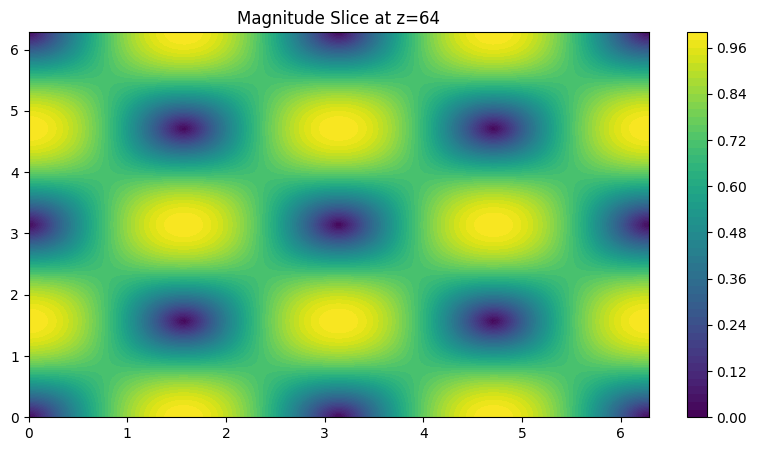

In [27]:
# 计算速度场的大小
U_magnitude = np.sqrt(U_x**2 + U_y**2 + U_z**2)

# 可视化速度场的切片
plot_slice_3d(U_magnitude, X, Y, Z, size // 2)


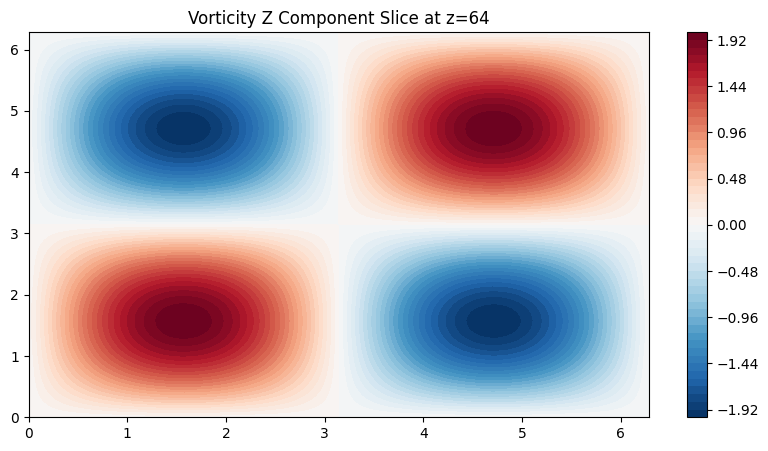

In [28]:
def plot_vorticity_slice(vorticity, X, Y, Z, slice_index, axis='z'):
    plt.figure(figsize=(10, 5))
    vort_x, vort_y, vort_z = vorticity
    if axis == 'z':
        plt.contourf(X[:, :, slice_index], Y[:, :, slice_index], vort_z[:, :, slice_index], levels=50, cmap='RdBu_r')
        plt.title('Vorticity Z Component Slice at z={}'.format(slice_index))
    elif axis == 'y':
        plt.contourf(X[:, slice_index, :], Z[:, slice_index, :], vort_y[:, slice_index, :], levels=50, cmap='RdBu_r')
        plt.title('Vorticity Y Component Slice at y={}'.format(slice_index))
    elif axis == 'x':
        plt.contourf(Y[slice_index, :, :], Z[slice_index, :, :], vort_x[slice_index, :, :], levels=50, cmap='RdBu_r')
        plt.title('Vorticity X Component Slice at x={}'.format(slice_index))
    plt.colorbar()
    plt.show()

# 计算旋度
vorticity = compute_vorticity_3d(U_x, U_y, U_z, dx, dy, dz)

# 可视化旋度的切片
plot_vorticity_slice(vorticity, X, Y, Z, size // 2, axis='z')


##### 数据准备

In [35]:
# 将数据转换为PyTorch张量
U_x_tensor = torch.tensor(U_x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_y_tensor = torch.tensor(U_y, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_z_tensor = torch.tensor(U_z, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_magnitude_tensor = torch.tensor(U_magnitude, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# 合并速度场作为输入
velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_z_tensor, U_magnitude_tensor), dim=1)

# 目标abcd (假设为0初始化)
target_abcd = torch.zeros((1, 4, size, size, size), dtype=torch.float32)

# 创建数据集和数据加载器
dataset = TensorDataset(velocity_field, target_abcd)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [139]:
dataset, dataloader

(<torch.utils.data.dataset.TensorDataset at 0x1c50010b790>,
 <torch.utils.data.dataloader.DataLoader at 0x1c5000f3940>)

In [52]:
class Basic3DModel(nn.Module):
    def __init__(self):
        super(Basic3DModel, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=4, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(32)
        self.conv2 = nn.Conv3d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(64)
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2, padding=0)
        self.deconv1 = nn.ConvTranspose3d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose3d(32, 16, kernel_size=4, stride=2, padding=1)  # 添加一个额外的反卷积层
        self.final_conv = nn.Conv3d(16, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))  # 使用新的反卷积层
        x = self.final_conv(x)
        return x

In [53]:
for inputs, targets in dataloader:
    print(f'Inputs size: {inputs.size()}')
    print(f'Targets size: {targets.size()}')
    break

Inputs size: torch.Size([1, 4, 128, 128, 128])
Targets size: torch.Size([1, 4, 128, 128, 128])


In [134]:
def loss_function(predicted_abcd, true_velocity):
    # 提取 a, b, c, d
    a = predicted_abcd[:, 0, :, :, :]
    b = predicted_abcd[:, 1, :, :, :]
    c = predicted_abcd[:, 2, :, :, :]
    d = predicted_abcd[:, 3, :, :, :]

    # 根据 a, b, c, d 计算预测的速度场
    u_x_pred = a + b
    u_y_pred = c + d
    u_z_pred = a - d
    U_magnitude_pred = torch.sqrt(u_x_pred**2 + u_y_pred**2 + u_z_pred**2)

    # 提取真实的速度场
    U_x_true = true_velocity[:, 0, :, :, :]
    U_y_true = true_velocity[:, 1, :, :, :]
    U_z_true = true_velocity[:, 2, :, :, :]
    U_magnitude_true = true_velocity[:, 3, :, :, :]  # 假设 true_velocity 包含 magnitude

    # 计算速度场的损失
    loss_velocity_x = F.mse_loss(u_x_pred, U_x_true)
    loss_velocity_y = F.mse_loss(u_y_pred, U_y_true)
    loss_velocity_z = F.mse_loss(u_z_pred, U_z_true)
    loss_magnitude = F.mse_loss(U_magnitude_pred, U_magnitude_true)

    # 总损失
    total_loss =  loss_magnitude
    return total_loss


In [135]:
# 创建模型实例
model = Basic3DModel()

# 定义损失函数和优化器
criterion = loss_function
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 设置训练过程
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in dataloader:
            # 将数据传送到GPU（如果可用）
            inputs, targets = inputs.to(device), targets.to(device)


            torch.cuda.empty_cache()

            # 前向传播
            outputs = model(inputs)

            # 计算损失
            loss = criterion(outputs, targets)

           # 反向传播和优化
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')


In [136]:
# 检查是否有可用的GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


Basic3DModel(
  (conv1): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (deconv1): ConvTranspose3d(64, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (deconv2): ConvTranspose3d(32, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
  (final_conv): Conv3d(16, 4, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

In [137]:
train_model(model, dataloader, criterion, optimizer, num_epochs=100)

Epoch 1/100, Loss: 0.0022
Epoch 2/100, Loss: 0.0015
Epoch 3/100, Loss: 0.0011
Epoch 4/100, Loss: 0.0008
Epoch 5/100, Loss: 0.0006
Epoch 6/100, Loss: 0.0005
Epoch 7/100, Loss: 0.0005
Epoch 8/100, Loss: 0.0004
Epoch 9/100, Loss: 0.0004
Epoch 10/100, Loss: 0.0003
Epoch 11/100, Loss: 0.0003
Epoch 12/100, Loss: 0.0003
Epoch 13/100, Loss: 0.0002
Epoch 14/100, Loss: 0.0002
Epoch 15/100, Loss: 0.0002
Epoch 16/100, Loss: 0.0002
Epoch 17/100, Loss: 0.0002
Epoch 18/100, Loss: 0.0002
Epoch 19/100, Loss: 0.0001
Epoch 20/100, Loss: 0.0001
Epoch 21/100, Loss: 0.0001
Epoch 22/100, Loss: 0.0001
Epoch 23/100, Loss: 0.0001
Epoch 24/100, Loss: 0.0001
Epoch 25/100, Loss: 0.0001
Epoch 26/100, Loss: 0.0001
Epoch 27/100, Loss: 0.0001
Epoch 28/100, Loss: 0.0001
Epoch 29/100, Loss: 0.0001
Epoch 30/100, Loss: 0.0001
Epoch 31/100, Loss: 0.0001
Epoch 32/100, Loss: 0.0001
Epoch 33/100, Loss: 0.0001
Epoch 34/100, Loss: 0.0001
Epoch 35/100, Loss: 0.0001
Epoch 36/100, Loss: 0.0001
Epoch 37/100, Loss: 0.0001
Epoch 38/1

In [122]:
U_x_test_tensor = torch.tensor(U_x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_y_test_tensor = torch.tensor(U_y, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_z_test_tensor = torch.tensor(U_z, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
U_magnitude_test_tensor = torch.tensor(U_magnitude, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

velocity_field_test = torch.cat((U_x_test_tensor, U_y_test_tensor, U_z_test_tensor, U_magnitude_test_tensor), dim=1)
target_test_abcd = torch.zeros((1, 4, size, size, size), dtype=torch.float32)
test_dataset = TensorDataset(velocity_field_test, target_test_abcd)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [123]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def test_model(model, test_loader):
    model.eval()  # 切换模型到评估模式
    mse_loss = 0.0
    psnr_value = 0.0
    ssim_value = 0.0
    num_batches = 0

    with torch.no_grad():  # 禁用梯度计算
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            # 计算MSE
            mse = criterion(outputs, targets).item()
            mse_loss += mse

            # 将张量转换为numpy数组以计算PSNR和SSIM
            outputs_np = outputs.cpu().numpy().squeeze()
            targets_np = targets.cpu().numpy().squeeze()

            # 计算PSNR
            psnr = peak_signal_noise_ratio(targets_np, outputs_np)
            psnr_value += psnr

            # 计算SSIM，设置合适的win_size和channel_axis
            ssim = structural_similarity(targets_np, outputs_np, data_range=outputs_np.max() - outputs_np.min(), win_size=3, channel_axis=0)
            ssim_value += ssim

            num_batches += 1

    # 计算平均值
    mse_loss /= num_batches
    psnr_value /= num_batches
    ssim_value /= num_batches

    return mse_loss, psnr_value, ssim_value

# 测试模型
mse_loss, psnr_value, ssim_value = test_model(model, test_loader)

print(f"Test MSE: {mse_loss:.6f}")
print(f"Test PSNR: {psnr_value:.2f}")
print(f"Test SSIM: {ssim_value:.2f}")


Test MSE: 0.000002
Test PSNR: 33.85
Test SSIM: 0.00


In [124]:
def visualize_results(inputs, outputs, targets, slice_index=64):
    inputs_np = inputs.cpu().numpy().squeeze()
    outputs_np = outputs.cpu().numpy().squeeze()
    targets_np = targets.cpu().numpy().squeeze()

    fig, axes = plt.subplots(3, 4, figsize=(20, 15))

    # 输入切片
    axes[0, 0].imshow(inputs_np[0, :, :, slice_index], cmap='viridis')
    axes[0, 0].set_title('Input X Component')
    axes[0, 1].imshow(inputs_np[1, :, :, slice_index], cmap='viridis')
    axes[0, 1].set_title('Input Y Component')
    axes[0, 2].imshow(inputs_np[2, :, :, slice_index], cmap='viridis')
    axes[0, 2].set_title('Input Z Component')
    axes[0, 3].imshow(inputs_np[3, :, :, slice_index], cmap='viridis')
    axes[0, 3].set_title('Input Magnitude')

    # 输出切片
    axes[1, 0].imshow(outputs_np[0, :, :, slice_index], cmap='viridis')
    axes[1, 0].set_title('Output A Component')
    axes[1, 1].imshow(outputs_np[1, :, :, slice_index], cmap='viridis')
    axes[1, 1].set_title('Output B Component')
    axes[1, 2].imshow(outputs_np[2, :, :, slice_index], cmap='viridis')
    axes[1, 2].set_title('Output C Component')
    axes[1, 3].imshow(outputs_np[3, :, :, slice_index], cmap='viridis')
    axes[1, 3].set_title('Output D Component')

    # 目标切片
    axes[2, 0].imshow(targets_np[0, :, :, slice_index], cmap='viridis')
    axes[2, 0].set_title('Target A Component')
    axes[2, 1].imshow(targets_np[1, :, :, slice_index], cmap='viridis')
    axes[2, 1].set_title('Target B Component')
    axes[2, 2].imshow(targets_np[2, :, :, slice_index], cmap='viridis')
    axes[2, 2].set_title('Target C Component')
    axes[2, 3].imshow(targets_np[3, :, :, slice_index], cmap='viridis')
    axes[2, 3].set_title('Target D Component')

    plt.tight_layout()
    plt.show()


In [125]:
# 从测试数据集中获取一批数据
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)

# 使用模型进行预测
with torch.no_grad():
    outputs = model(inputs)

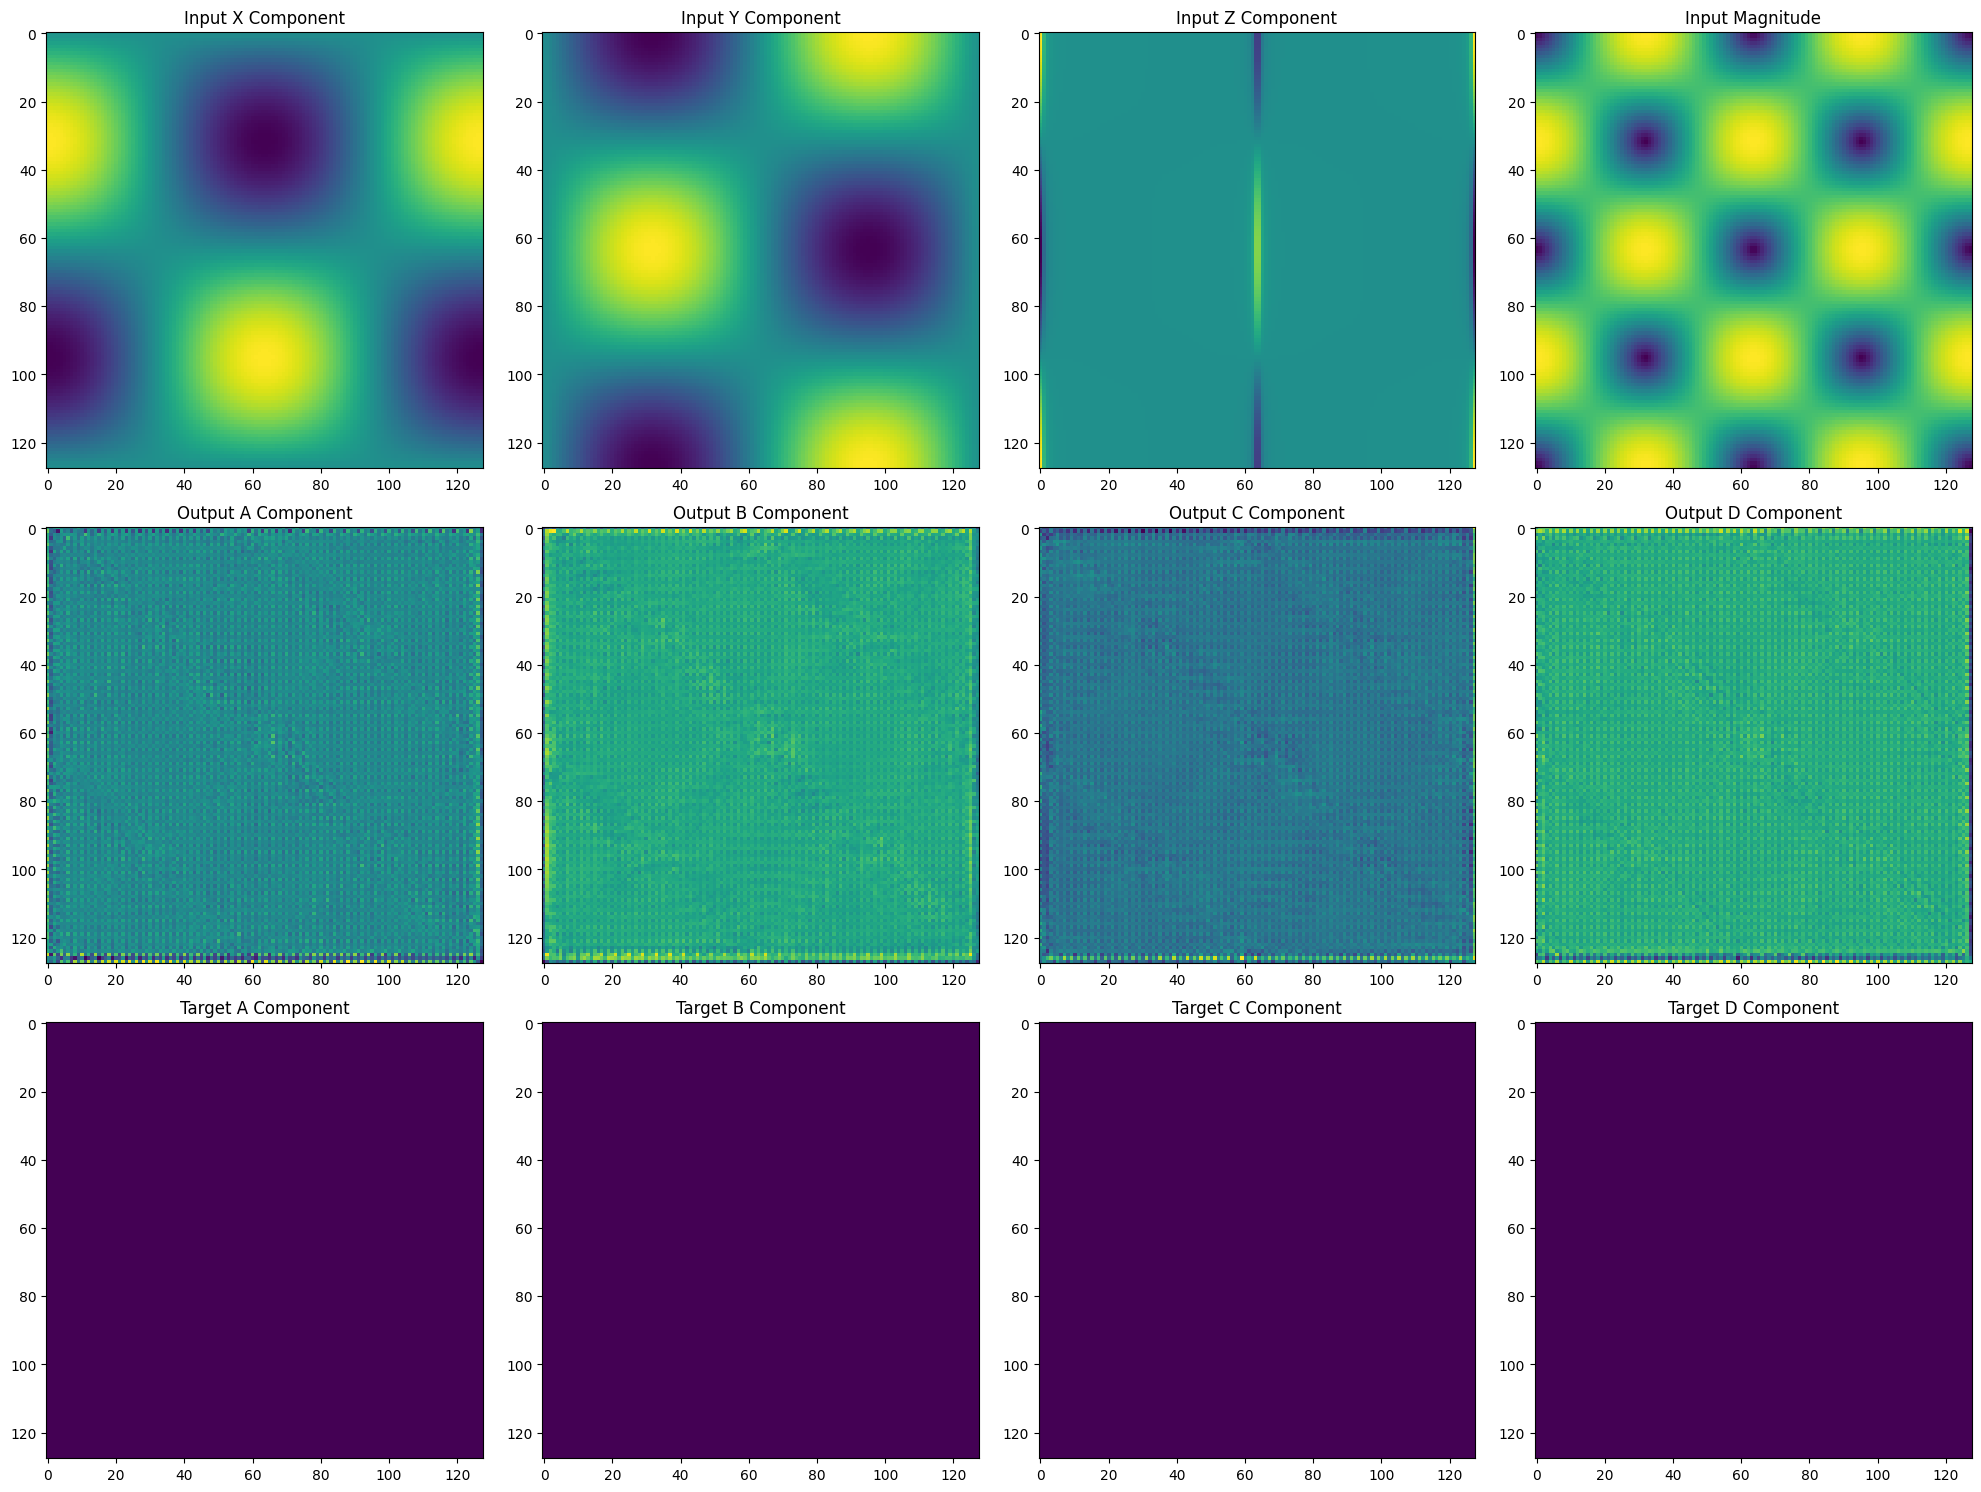

In [126]:
visualize_results(inputs, outputs, targets)

In [127]:
a_pred = outputs[0, 0].cpu().numpy()
b_pred = outputs[0, 1].cpu().numpy()
c_pred = outputs[0, 2].cpu().numpy()
d_pred = outputs[0, 3].cpu().numpy()

a_pred.shape    

(128, 128, 128)

In [128]:
def compute_velocity_field_3d_np(x, y, z, dx, dy, dz):
    a_val = a_pred.copy()
    b_val = b_pred.copy()
    c_val = c_pred.copy()
    d_val = d_pred.copy()

    a_grad_x, a_grad_y, a_grad_z = np.gradient(a_val, dx, dy, dz)
    b_grad_x, b_grad_y, b_grad_z = np.gradient(b_val, dx, dy, dz)
    c_grad_x, c_grad_y, c_grad_z = np.gradient(c_val, dx, dy, dz)
    d_grad_x, d_grad_y, d_grad_z = np.gradient(d_val, dx, dy, dz)

    u_x = hbar * (a_val * b_grad_x - b_val * a_grad_x + c_val * d_grad_x - d_val * c_grad_x)
    u_y = hbar * (a_val * b_grad_y - b_val * a_grad_y + c_val * d_grad_y - d_val * c_grad_y)
    u_z = hbar * (a_val * b_grad_z - b_val * a_grad_z + c_val * d_grad_z - d_val * c_grad_z)

    return u_x, u_y, u_z

In [129]:
X.shape

(128, 128, 128)

In [130]:
u_x_pred, u_y_pred, u_z_pred = compute_velocity_field_3d_np(X, Y, Z, dx, dy, dz)


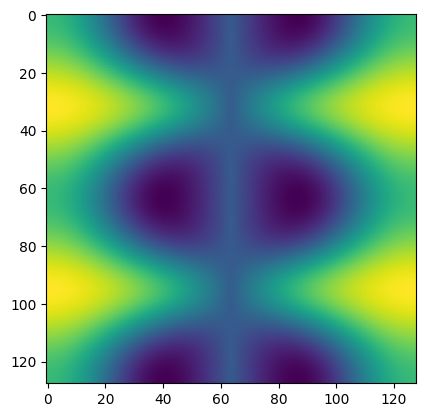

In [131]:
plt.imshow(a(X, Y, Z)[:, :, size // 2], cmap='viridis')

In [132]:
a(X, Y, Z).shape

(128, 128, 128)

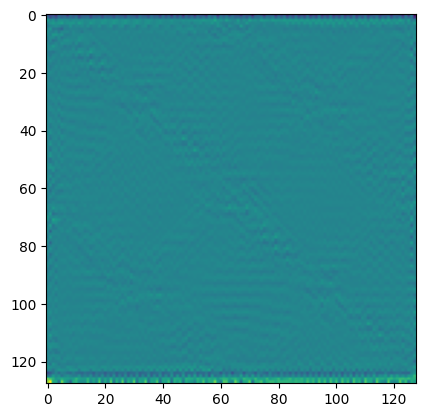

In [133]:
plt.imshow(u_x_pred[:, :, size // 2], cmap='viridis')